In [1]:
import sys
sys.path.append('/Users/yuch8913/miniforge3/envs/er3t_env/lib/python3.8/site-packages')
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from glob import glob
import numpy as np
from sys import exit as ext
import copy
from bisect import bisect_left
from oco_post_class_ywc import *
from matplotlib import cm
from scipy.interpolate import interpn
from scipy import stats
import geopy.distance
import xarray as xr
import seaborn as sns
from tool_code import *
%matplotlib inline
import os, pickle 
#"""

from matplotlib import font_manager

font_path = '/System/Library/Fonts/Supplemental/Arial.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#"""

import warnings
warnings.filterwarnings("ignore")

In [2]:
png       = ['../simulation/data/20181018_central_asia_2_470cloud_test_20181018/aqua_rgb_2018-10-18_55.00-55.60-33.70-34.45.png',
             [55.00, 55.60, 33.70, 34.45]]
img = png[0]
wesn= png[1]

In [3]:
def grab_cfg(path):
    """
    Read the setting information in the assigned csv file.
    path: relative or absolute path to the setting csv file.
    """
    cfg_file = pd.read_csv(path, header=None, index_col=0)
    result = {'cfg_name':path.split('/')[-1].replace('.csv', '')}
    for ind in cfg_file.index.dropna():
        contents = [str(i) for i in cfg_file.loc[ind].dropna() if str(i)[0] != '#']
        if len(contents) == 1:
            result[ind] = contents[0]
        elif len(contents) > 1:
            result[ind] = contents
    return result

def output_h5_info(cfg, index):
    """
    Check whether the output h5 name is saved in cfg file
    """
    try: 
        cfg_file = grab_cfg(cfg)
    except OSError as err:
        print('{} not exists!'.format(cfg))
        return False
    if index in cfg_file.keys():
        if cfg_file[index][-2:] == 'h5':
            return cfg_file[index]
    else:
        return False
    
def get_slope_1km(OCO_class,fp,z,mode='unperturb'):
    nwl=OCO_class.sls_1km[z,fp,:].shape[0]
    flt=np.where(OCO_class.sls_1km[z,fp,:]>1e-6)
    #flt=np.where(~np.isnan(sls[:]))
    use=len(flt[0])
    if use==nwl:
        w=1./OCO_class.sls_1km[z,fp,:]    
        if mode=='unperturb':
            x=OCO_class.rad_1km_c3d[z,fp,:]/OCO_class.toa[:]*np.pi
        else:
            x=OCO_class.rad_1km_clr[z,fp,:]/OCO_class.toa[:]*np.pi
        mask = np.argsort(x)[5:]
        res=np.polyfit(x[mask],OCO_class.sl_1km[z,fp,:][mask],1,w=w[mask],cov=True) # now get covariance as well!
        slope,intercept=res[0]
        slopestd=np.sqrt(res[1][0][0])
        interceptstd=np.sqrt(res[1][1][1])
    else:
        slope=np.nan; slopestd=np.nan; intercept=np.nan; interceptstd=np.nan
    return(slope,slopestd,intercept,interceptstd)

def get_slope_1km_all(OCO_class,fp,z,mode='unperturb'):
    nwl=OCO_class.sls_1km_all[z,fp,:].shape[0]
    flt=np.where(OCO_class.sls_1km_all[z,fp,:]>1e-6)
    #flt=np.where(~np.isnan(sls[:]))
    use=len(flt[0])
    if use==nwl:
        w=1./OCO_class.sls_1km_all[z,fp,:]    
        if mode=='unperturb':
            x=OCO_class.rad_1km_c3d_all[z,fp,:]/OCO_class.toa[:]*np.pi
        else:
            x=OCO_class.rad_1km_clr_all[z,fp,:]/OCO_class.toa[:]*np.pi
        mask = np.argsort(x)[5:]
        res=np.polyfit(x[mask],OCO_class.sl_1km_all[z,fp,:][mask],1,w=w[mask],cov=True) # now get covariance as well!
        slope,intercept=res[0]
        slopestd=np.sqrt(res[1][0][0])
        interceptstd=np.sqrt(res[1][1][1])
    else:
        slope=np.nan; slopestd=np.nan; intercept=np.nan; interceptstd=np.nan
    return(slope,slopestd,intercept,interceptstd)

def get_slope_25p(OCO_class,fp,z,mode='unperturb'):
    nwl=OCO_class.sls_25p[z,fp,:].shape[0]
    flt=np.where(OCO_class.sls_25p[z,fp,:]>1e-6)
    #flt=np.where(~np.isnan(sls[:]))
    use=len(flt[0])
    if use==nwl:
        w=1./OCO_class.sls_25p[z,fp,:]
        if mode=='unperturb':
            x=OCO_class.rad_25p_c3d[z,fp,:]/OCO_class.toa[:]*np.pi
        else:
            x=OCO_class.rad_25p_clr[z,fp,:]/OCO_class.toa[:]*np.pi   
        mask = np.argsort(x)[5:]
        res=np.polyfit(x[mask],OCO_class.sl_25p[z,fp,:][mask],1,w=w[mask],cov=True) # now get covariance as well!
        slope,intercept=res[0]
        slopestd=np.sqrt(res[1][0][0])
        interceptstd=np.sqrt(res[1][1][1])
    else:
        slope=np.nan; slopestd=np.nan; intercept=np.nan; interceptstd=np.nan
    return(slope,slopestd,intercept,interceptstd)

def slopes_propagation(OCO_class,mode='unperturb'): # goes through entire line for a given footprint fp
    OCO_class.slope_1km=np.zeros([OCO_class.nz,OCO_class.nf,2])
    OCO_class.inter_1km=np.zeros([OCO_class.nz,OCO_class.nf,2])
    OCO_class.slope_25p=np.zeros([OCO_class.nz,OCO_class.nf,2])
    OCO_class.inter_25p=np.zeros([OCO_class.nz,OCO_class.nf,2])
    OCO_class.slope_1km_all=np.zeros([OCO_class.rad_1km_clr_all.shape[0],OCO_class.rad_1km_clr_all.shape[1], 2])
    OCO_class.inter_1km_all=np.zeros([OCO_class.rad_1km_clr_all.shape[0],OCO_class.rad_1km_clr_all.shape[1], 2])
    for z in range(OCO_class.nz):
        for fp in range(OCO_class.nf):
            if 1:#~ np.isnan(OCO_class.co2[z,fp,]):
                slope,slopestd,inter,interstd=OCO_class.get_slope(fp,z,mode='unperturb')
                OCO_class.slope[z,fp,:]=[slope,slopestd]
                OCO_class.inter[z,fp,:]=[inter,interstd]
                slope,slopestd,inter,interstd=get_slope_1km(OCO_class, fp,z,mode='unperturb')
                OCO_class.slope_1km[z,fp,:]=[slope,slopestd]
                OCO_class.inter_1km[z,fp,:]=[inter,interstd]  
                slope,slopestd,inter,interstd=get_slope_25p(OCO_class, fp,z,mode='unperturb')
                OCO_class.slope_25p[z,fp,:]=[slope,slopestd]
                OCO_class.inter_25p[z,fp,:]=[inter,interstd]  
    for z in range(OCO_class.rad_1km_clr_all.shape[0]):
        for fp in range(OCO_class.rad_1km_clr_all.shape[1]):   
            slope,slopestd,inter,interstd=get_slope_1km_all(OCO_class, fp,z,mode='unperturb')
            OCO_class.slope_1km_all[z,fp,:]=[slope,slopestd]
            OCO_class.inter_1km_all[z,fp,:]=[inter,interstd]

In [4]:
def plot_perturbation_1km(OCOSIM,z,fp,frame=None):
        if frame is None:
            f,frame=plt.subplots()
        frame.plot(OCOSIM.rad_1km_c3d[z,fp,:]/OCOSIM.toa*np.pi,OCOSIM.sl_1km[z,fp,:]*100,'ko')    
        for l,wl in enumerate(OCOSIM.lam):
            frame.plot([OCOSIM.rad_1km_c3d[z,fp,l]/OCOSIM.toa[l]*np.pi,OCOSIM.rad_1km_c3d[z,fp,l]/OCOSIM.toa[l]*np.pi],
                     np.array([OCOSIM.sl_1km[z,fp,l]-OCOSIM.sls_1km[z,fp,l],OCOSIM.sl_1km[z,fp,l]+OCOSIM.sls_1km[z,fp,l]])*100,'k:')        
        slope,slopes         = OCOSIM.slope_1km[z,fp,:]
        intercept,intercepts = OCOSIM.inter_1km[z,fp,:]
        mn = np.min(OCOSIM.rad_1km_c3d[z,fp,:]/OCOSIM.toa[:]*np.pi)
        mx = np.max(OCOSIM.rad_1km_c3d[z,fp,:]/OCOSIM.toa[:]*np.pi)
        xx=np.linspace(mn,mx,10)
        yy=intercept+slope*xx
        y1=intercept+intercepts+(slope+slopes)*xx
        y2=intercept-intercepts+(slope-slopes)*xx
        frame.plot(xx,yy*100,'r-',linewidth=2)  
        frame.plot(xx,y1*100,'r:',linewidth=1)  
        frame.plot(xx,y2*100,'r:',linewidth=1)  
        frame.plot([0,mx],[0,0],'k--')
        # ywc added
        frame.set_title(f'slope: {slope:.3f}\nintercept: {intercept*100:.1f}')
        frame.set_ylim(-30, 30)

In [5]:
def near_rad_calc(OCO_class):
    rad_mca_ipa0 = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)
    rad_mca_ipa  = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)
    rad_mca_3d   = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)

    rad_mca_ipa0_std = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)
    rad_mca_ipa_std  = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)
    rad_mca_3d_std   = np.zeros((OCO_class.lat.shape[0], OCO_class.lat.shape[1], OCO_class.lam.size), dtype=np.float64)

    rad_mca_ipa0[...] = np.nan
    rad_mca_ipa[...] = np.nan
    rad_mca_3d[...] = np.nan

    rad_mca_ipa0_std[...] = np.nan
    rad_mca_ipa_std[...] = np.nan
    rad_mca_3d_std[...] = np.nan

    rad_mca_ipa0_25 = rad_mca_ipa0.copy()
    rad_mca_ipa_25 = rad_mca_ipa0.copy()
    rad_mca_3d_25 = rad_mca_ipa0.copy()

    rad_mca_ipa0_std_25 = rad_mca_ipa0.copy()
    rad_mca_ipa_std_25 = rad_mca_ipa0.copy()
    rad_mca_3d_std_25 = rad_mca_ipa0.copy()
    count = 0
    for i in range(OCO_class.lat.shape[0]):
        for j in range(OCO_class.lat.shape[1]):
            if 1:#~ np.isnan(OCO_class.co2[i, j]):
                lon0 = OCO_class.lon[i, j]
                lat0 = OCO_class.lat[i, j]      
                index_lon = np.argmin(np.abs(OCO_class.lon2d[:, 0]-lon0))
                index_lat = np.argmin(np.abs(OCO_class.lat2d[0, :]-lat0))

                center = (lat0, lon0)
                tmp_clr, tmp_c1d, tmp_c3d = [], [], []
                tmp_clrs, tmp_c1ds, tmp_c3ds = [], [], []
                test_range = (np.arange(-10, 10+1))
                for x in test_range:
                    for y in test_range:
                        try:
                            interest_loc = (OCO_class.lat2d[0, index_lat+y], OCO_class.lon2d[index_lon+x, 0])
                            if geopy.distance.distance(center, interest_loc).km <= 1.0:

                                tmp_clr.append(OCO_class.rad_clr[index_lon+x, index_lat+y])
                                tmp_c1d.append(OCO_class.rad_c1d[index_lon+x, index_lat+y])
                                tmp_c3d.append(OCO_class.rad_c3d[index_lon+x, index_lat+y])
                                tmp_clrs.append(OCO_class.rad_clrs[index_lon+x, index_lat+y])
                                tmp_c1ds.append(OCO_class.rad_c1ds[index_lon+x, index_lat+y])
                                tmp_c3ds.append(OCO_class.rad_c3ds[index_lon+x, index_lat+y])
                                count += 1
                        except:
                            None
                
                rad_mca_ipa0[i, j, :] = np.nanmean(np.array(tmp_clr), axis=0)
                rad_mca_ipa[i, j, :]  = np.nanmean(np.array(tmp_c1d), axis=0)
                rad_mca_3d[i, j, :]   = np.nanmean(np.array(tmp_c3d), axis=0)

                rad_mca_ipa0_std[i, j, :] = (np.nanstd(np.array(tmp_clr), axis=0))
                rad_mca_ipa_std[i, j, :]  = (np.nanstd(np.array(tmp_c1d), axis=0))
                rad_mca_3d_std[i, j, :]   = (np.nanstd(np.array(tmp_c3d), axis=0))


                rad_mca_ipa0_25[i, j, :] = np.nanmean(OCO_class.rad_clr[index_lon-2:index_lon+3, 
                                                                 index_lat-2:index_lat+3], 
                                                      axis=(0, 1))
                rad_mca_ipa_25[i, j, :]  = np.nanmean(OCO_class.rad_c1d[index_lon-2:index_lon+3, 
                                                                 index_lat-2:index_lat+3], 
                                                      axis=(0, 1))
                rad_mca_3d_25[i, j, :]   = np.nanmean(OCO_class.rad_c3d[index_lon-2:index_lon+3, 
                                                                 index_lat-2:index_lat+3], 
                                                      axis=(0, 1))
                
                rad_mca_ipa0_std_25[i, j, :] = (np.nanstd(OCO_class.rad_clr[index_lon-2:index_lon+3,
                                                                      index_lat-2:index_lat+3],
                                                          axis=(0, 1)))
                rad_mca_ipa_std_25[i, j, :]  = (np.nanstd(OCO_class.rad_c1d[index_lon-2:index_lon+3,
                                                                      index_lat-2:index_lat+3],
                                                          axis=(0, 1)))
                rad_mca_3d_std_25[i, j, :]   = (np.nanstd(OCO_class.rad_c3d[index_lon-2:index_lon+3,
                                                                      index_lat-2:index_lat+3],
                                                          axis=(0, 1)))
    print(count)
    OCO_class.rad_1km_clr = rad_mca_ipa0
    OCO_class.rad_1km_c1d = rad_mca_ipa
    OCO_class.rad_1km_c3d = rad_mca_3d

    OCO_class.rad_1km_clrs = rad_mca_ipa0_std
    OCO_class.rad_1km_c1ds = rad_mca_ipa_std
    OCO_class.rad_1km_c3ds = rad_mca_3d_std

    OCO_class.rad_25p_clr = rad_mca_ipa0_25
    OCO_class.rad_25p_c1d = rad_mca_ipa_25
    OCO_class.rad_25p_c3d = rad_mca_3d_25

    OCO_class.rad_25p_clrs = rad_mca_ipa0_std_25
    OCO_class.rad_25p_c1ds = rad_mca_ipa_std_25
    OCO_class.rad_25p_c3ds = rad_mca_3d_std_25
    
    OCO_class.sl_1km  = (OCO_class.rad_1km_c3d-OCO_class.rad_1km_clr) / OCO_class.rad_1km_clr        # S_lamda
    OCO_class.sls_1km = (OCO_class.rad_1km_c3ds/OCO_class.rad_1km_clr + OCO_class.rad_1km_clrs/OCO_class.rad_1km_clr)
    OCO_class.sl_25p  = (OCO_class.rad_25p_c3d-OCO_class.rad_25p_clr) / OCO_class.rad_25p_clr        # S_lamda
    OCO_class.sls_25p = (OCO_class.rad_25p_c3ds/OCO_class.rad_25p_clr + OCO_class.rad_25p_clrs/OCO_class.rad_25p_clr)

In [6]:
def near_rad_calc_all(OCO_class):
    interval = 3
    rad_mca_ipa0 = np.zeros((OCO_class.lat2d.shape[0]//interval, OCO_class.lat2d.shape[1]//interval, OCO_class.lam.size), dtype=np.float64)
    rad_mca_ipa  = np.zeros((OCO_class.lat2d.shape[0]//interval, OCO_class.lat2d.shape[1]//interval, OCO_class.lam.size), dtype=np.float64)
    rad_mca_3d   = np.zeros((OCO_class.lat2d.shape[0]//interval, OCO_class.lat2d.shape[1]//interval, OCO_class.lam.size), dtype=np.float64)

    rad_mca_ipa0_std = np.zeros((OCO_class.lat2d.shape[0]//interval, OCO_class.lat2d.shape[1]//interval, OCO_class.lam.size), dtype=np.float64)
    rad_mca_ipa_std  = np.zeros((OCO_class.lat2d.shape[0]//interval, OCO_class.lat2d.shape[1]//interval, OCO_class.lam.size), dtype=np.float64)
    rad_mca_3d_std   = np.zeros((OCO_class.lat2d.shape[0]//interval, OCO_class.lat2d.shape[1]//interval, OCO_class.lam.size), dtype=np.float64)

    print(rad_mca_ipa0.shape)
    rad_mca_ipa0[...] = np.nan
    rad_mca_ipa[...] = np.nan
    rad_mca_3d[...] = np.nan

    rad_mca_ipa0_std[...] = np.nan
    rad_mca_ipa_std[...] = np.nan
    rad_mca_3d_std[...] = np.nan

    rad_mca_ipa0_25 = rad_mca_ipa0.copy()
    rad_mca_ipa_25 = rad_mca_ipa0.copy()
    rad_mca_3d_25 = rad_mca_ipa0.copy()

    rad_mca_ipa0_std_25 = rad_mca_ipa0.copy()
    rad_mca_ipa_std_25 = rad_mca_ipa0.copy()
    rad_mca_3d_std_25 = rad_mca_ipa0.copy()
    count = 0
    lon_all, lat_all = [], []
    for i in range(OCO_class.lat2d.shape[0]//interval):
        for j in range(OCO_class.lat2d.shape[1]//interval):
            lon0 = OCO_class.lon2d[i*interval, j*interval]
            lat0 = OCO_class.lat2d[i*interval, j*interval]   
            lon_all.append(lon0)
            lat_all.append(lat0)
            index_lon = np.argmin(np.abs(OCO_class.lon2d[:, 0]-lon0))
            index_lat = np.argmin(np.abs(OCO_class.lat2d[0, :]-lat0))

            center = (lat0, lon0)
            tmp_clr, tmp_c1d, tmp_c3d = [], [], []
            tmp_clrs, tmp_c1ds, tmp_c3ds = [], [], []
            test_range = (np.arange(-10, 10+1))
            for x in test_range:
                for y in test_range:
                    try:
                        interest_loc = (OCO_class.lat2d[0, index_lat+y], OCO_class.lon2d[index_lon+x, 0])
                        if geopy.distance.distance(center, interest_loc).km <= 1.0:

                            tmp_clr.append(OCO_class.rad_clr[index_lon+x, index_lat+y])
                            tmp_c1d.append(OCO_class.rad_c1d[index_lon+x, index_lat+y])
                            tmp_c3d.append(OCO_class.rad_c3d[index_lon+x, index_lat+y])
                            tmp_clrs.append(OCO_class.rad_clrs[index_lon+x, index_lat+y])
                            tmp_c1ds.append(OCO_class.rad_c1ds[index_lon+x, index_lat+y])
                            tmp_c3ds.append(OCO_class.rad_c3ds[index_lon+x, index_lat+y])
                            count += 1
                    except:
                        None

            rad_mca_ipa0[i, j, :] = np.nanmean(np.array(tmp_clr), axis=0)
            rad_mca_ipa[i, j, :]  = np.nanmean(np.array(tmp_c1d), axis=0)
            rad_mca_3d[i, j, :]   = np.nanmean(np.array(tmp_c3d), axis=0)

            rad_mca_ipa0_std[i, j, :] = (np.nanstd(np.array(tmp_clr), axis=0))
            rad_mca_ipa_std[i, j, :]  = (np.nanstd(np.array(tmp_c1d), axis=0))
            rad_mca_3d_std[i, j, :]   = (np.nanstd(np.array(tmp_c3d), axis=0))


            rad_mca_ipa0_25[i, j, :] = np.nanmean(OCO_class.rad_clr[index_lon-2:index_lon+3, 
                                                             index_lat-2:index_lat+3], 
                                                  axis=(0, 1))
            rad_mca_ipa_25[i, j, :]  = np.nanmean(OCO_class.rad_c1d[index_lon-2:index_lon+3, 
                                                             index_lat-2:index_lat+3], 
                                                  axis=(0, 1))
            rad_mca_3d_25[i, j, :]   = np.nanmean(OCO_class.rad_c3d[index_lon-2:index_lon+3, 
                                                             index_lat-2:index_lat+3], 
                                                  axis=(0, 1))

            rad_mca_ipa0_std_25[i, j, :] = (np.nanstd(OCO_class.rad_clr[index_lon-2:index_lon+3,
                                                                  index_lat-2:index_lat+3],
                                                      axis=(0, 1)))
            rad_mca_ipa_std_25[i, j, :]  = (np.nanstd(OCO_class.rad_c1d[index_lon-2:index_lon+3,
                                                                  index_lat-2:index_lat+3],
                                                      axis=(0, 1)))
            rad_mca_3d_std_25[i, j, :]   = (np.nanstd(OCO_class.rad_c3d[index_lon-2:index_lon+3,
                                                                  index_lat-2:index_lat+3],
                                                      axis=(0, 1)))
    print(count)
    OCO_class.lon_all = lon_all
    OCO_class.lat_all = lat_all
    OCO_class.rad_1km_clr_all = rad_mca_ipa0
    OCO_class.rad_1km_c1d_all = rad_mca_ipa
    OCO_class.rad_1km_c3d_all = rad_mca_3d

    OCO_class.rad_1km_clrs_all = rad_mca_ipa0_std
    OCO_class.rad_1km_c1ds_all = rad_mca_ipa_std
    OCO_class.rad_1km_c3ds_all = rad_mca_3d_std

    OCO_class.rad_25p_clr_all = rad_mca_ipa0_25
    OCO_class.rad_25p_c1d_all = rad_mca_ipa_25
    OCO_class.rad_25p_c3d_all = rad_mca_3d_25

    OCO_class.rad_25p_clrs_all = rad_mca_ipa0_std_25
    OCO_class.rad_25p_c1ds_all = rad_mca_ipa_std_25
    OCO_class.rad_25p_c3ds_all = rad_mca_3d_std_25
    
    OCO_class.sl_1km_all  = (OCO_class.rad_1km_c3d_all-OCO_class.rad_1km_clr_all) / OCO_class.rad_1km_clr_all        # S_lamda
    OCO_class.sls_1km_all = (OCO_class.rad_1km_c3ds_all/OCO_class.rad_1km_clr_all + OCO_class.rad_1km_clrs_all/OCO_class.rad_1km_clr_all)
    OCO_class.sl_25p_all  = (OCO_class.rad_25p_c3d_all-OCO_class.rad_25p_clr_all) / OCO_class.rad_25p_clr_all        # S_lamda
    OCO_class.sls_25p_all = (OCO_class.rad_25p_c3ds_all/OCO_class.rad_25p_clr_all + OCO_class.rad_25p_clrs_all/OCO_class.rad_25p_clr_all)

In [7]:
id_list = []
cfg_dir = '../simulation/cfg'
cfg = '20181018_central_asia_2_470cloud_test.csv'
boundary_list = []

cfg_info = grab_cfg(f'{cfg_dir}/{cfg}')
if 'o2' in cfg_info.keys():
    id_list.append(output_h5_info(f'{cfg_dir}/{cfg}', 'o2')[-12:-3])
    boundary_list.append([[float(i) for i in cfg_info['subdomain']], 'r'])
else:
    boundary_list.append([[float(i) for i in cfg_info['subdomain']], 'orange'])
subdomain = cfg_info['subdomain']
id_list

['6170_6209']

In [57]:
if not os.path.isfile('20181018_central_asia_2_470cloud_test_avg_sfc_albedo_minus_0.2_sza_60_o2a.pkl'):
    for i in range(len(id_list)):
        id_num = id_list[i]
        #filename = '../simulation/output_1e8/data_all_20150622_{}_{}.h5'
        filename = '../simulation/data_all_20181018_{}_{}_avg_sfc_albedo_minus_0.2_sza_60.h5'
        o2a_file  = filename.format('o2a', id_num)
        #wco2_file = filename.format('wco2', id_num)
        #sco2_file = filename.format('sco2', id_num)
        for (var, varfile) in [('o1', o2a_file)]:#, ('o2', wco2_file), ('o3', sco2_file)]:
            vars()['{}_temp{}'.format(var, i)] = OCOSIM(varfile)
            for j in range(8):
                vars()['{}_temp{}'.format(var, i)].slopes(j)
            near_rad_calc(vars()['{}_temp{}'.format(var, i)])
            near_rad_calc_all(vars()['{}_temp{}'.format(var, i)])
            slopes_propagation(vars()['{}_temp{}'.format(var, i)])
    for var in ['o1']:#, 'o2', 'o3']:
        vars()[var] = copy.copy(vars()['{}_temp0'.format(var)])
        for i in range(1, len(id_list)):
            vars()[var].combine(vars()['{}_temp{}'.format(var, i)])
    file_o1 = open('20181018_central_asia_2_470cloud_test_avg_sfc_albedo_minus_0.2_sza_60_o2a.pkl', 'wb') 
    pickle.dump(o1, file_o1)

    """file_o2 = open('20181018_central_asia_2_470cloud_test_basic_wco2.pkl', 'wb')
    pickle.dump(o2, file_o2)

    file_o3 = open('20181018_central_asia_2_470cloud_test_basic_sco2.pkl', 'wb') 
    pickle.dump(o3, file_o3)"""

    file_o1.close()
    #file_o2.close()
    #file_o3.close()
else:
    with open('20181018_central_asia_2_470cloud_test_avg_sfc_avg_sfc_albedo_minus_0.2_sza_60_o2a.pkl', 'rb') as f:
        o1 = pickle.load(f)
    """with open('20181018_central_asia_2_470cloud_test_basic_wco2.pkl', 'rb') as f:
        o2 = pickle.load(f)
    with open('20181018_central_asia_2_470cloud_test_basic_sco2.pkl', 'rb') as f:
        o3 = pickle.load(f)"""

with open('20181018_central_asia_2_470cloud_wco2.pkl', 'rb') as f:
    o2 = pickle.load(f)
with open('20181018_central_asia_2_470cloud_sco2.pkl', 'rb') as f:
    o3 = pickle.load(f)

14842
(80, 100, 11)
403830


-0.4819408675188182


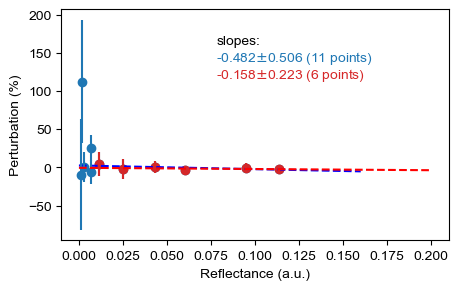

[0.00676779 0.00145274 0.0114865  0.00179253 0.00297742 0.04311087
 0.02508229 0.00700268 0.11336175 0.09507591 0.06001964]


-0.15760878342955176

In [58]:
z,fp = 17, 6
w=1./o1.sls[z,fp,:]    
x=o1.c3d[z,fp,:]/o1.toa[:]*np.pi
mask = np.argsort(x)[5:]
res=np.polyfit(x,o1.sl[z,fp,:],1,w=w,cov=True) # now get covariance as well!
slope_11,intercept_11=res[0]
slopestd_11=np.sqrt(res[1][0][0])

fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(x, o1.sl[z,fp,:]*100)
ax.plot([0, 0.16], (np.array([0, 0.16])*slope_11+intercept_11)*100, '--', color='blue')
ax.errorbar(x,o1.sl[z,fp,:]*100, yerr=o1.sls[z,fp,:]*100, color='tab:blue', ls='none')
print(slope_11)
res=np.polyfit(x[mask],o1.sl[z,fp,:][mask],1,w=w[mask],cov=True) # now get covariance as well!
slope,intercept=res[0]
slopestd=np.sqrt(res[1][0][0])
ax.errorbar(x[mask],o1.sl[z,fp,:][mask]*100, yerr=o1.sls[z,fp,:][mask]*100, color='tab:red', ls='none')
ax.scatter(x[mask], o1.sl[z,fp,:][mask]*100, c='tab:red')
ax.plot([0, 0.2], (np.array([0, 0.2])*slope+intercept)*100, '--', color='red')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.text((xmax-xmin)*0.4+xmin, (ymax-ymin)*0.85+ymin, 'slopes:')
ax.text((xmax-xmin)*0.4+xmin, (ymax-ymin)*0.775+ymin, f'{slope_11:.3f}$\pm${slopestd_11:.3f} (11 points)', color='tab:blue')
ax.text((xmax-xmin)*0.4+xmin, (ymax-ymin)*0.7+ymin, f'{slope:.3f}$\pm${slopestd:.3f} (6 points)', color='tab:red')
ax.set_xlabel('Reflectance (a.u.)')
ax.set_ylabel('Perturbation (%)')
plt.show()
print(x)
slope


In [17]:
litefile = '../dat/oco2_LtCO2_181018_B10206Ar_200730042453s.nc4'
lite = xr.open_dataset(litefile)
lite_snd = xr.open_dataset(litefile, group='Sounding')

In [18]:
cloudfile = '../steve/oco2_LtCO2_150622_B9003r_180928052221s_3Dmetrics.nc4'
cloud = xr.open_dataset(cloudfile)
#cloud

In [19]:
lon_w, lon_e = np.array(boundary_list)[0, 0][0], np.array(boundary_list)[0, 0][1]
lat_s, lat_n = np.array(boundary_list)[0, 0][2], np.array(boundary_list)[0, 0][3]
lon_range = np.logical_and(lite.longitude >= lon_w, lite.longitude <= lon_e)
lat_range = np.logical_and(lite.latitude >= lat_s, lite.latitude <= lat_n)

select = np.where(np.logical_and(lon_range, lat_range))
lite_snd_list = np.array(lite.sounding_id[select], dtype=np.int)


In [20]:
qf_array = np.zeros((o1.snd.shape[0], o1.snd.shape[1], 3))
alt_array = np.zeros_like(o1.snd, dtype=float)
cld_array = np.zeros((o1.snd.shape[0], o1.snd.shape[1], 4))
qf_lon, qf_lat = np.zeros((o1.snd.shape[0], o1.snd.shape[1])), np.zeros((o1.snd.shape[0], o1.snd.shape[1]))
# qf, qf_bitflag, qf_simpleflag\
for i in range(o1.snd.shape[0]):
    for j in range(o1.snd.shape[1]):
        snd = o1.snd[i, j]
        #print('-'*15)
        #print(snd)
        if snd in lite_snd_list:
            index = np.where(lite_snd_list == snd)[0][0]
            xco2_quality_flag = np.float(lite.xco2_quality_flag[select][index])
            xco2_qf_bitflag = np.float(lite.xco2_qf_bitflag[select][index])
            xco2_qf_simple_bitflag = np.float(lite.xco2_qf_simple_bitflag[select][index])
            qf_array[i, j, :] = (xco2_quality_flag, xco2_qf_bitflag, xco2_qf_simple_bitflag)
            qf_lat[i, j] = np.float(lite.latitude[select][index])
            qf_lon[i, j] = np.float(lite.longitude[select][index])
            alt_array[i, j] = np.float(lite_snd.altitude[select][index])
        else:
            qf_array[i, j, :] = (np.nan,)*3
            qf_lat[i, j] = np.nan
            qf_lon[i, j] = np.nan
            alt_array[i, j] = np.nan
        """if snd in cloud.sounding_id:
            index = np.where(cloud.sounding_id == snd)[0][0]
            cld_dist = np.float(cloud.cld_dist[index])
            h3d = np.float(cloud.h3d[index])
            cs_noise_ratio = np.float(cloud.cs_noise_ratio[index])
            hc = np.float(cloud.hc[index])
            cld_array[i, j, :] = (cld_dist, h3d, cs_noise_ratio, hc)
        else:
            cld_array[i, j, :] = (np.nan,)*4"""

In [21]:
qf0_index = np.where(qf_array[:,:,0]==0)

In [22]:
cld_list = []
for i in range(len(qf0_index[0])):
    cld_list.append(cld_array[qf0_index[0][i], qf0_index[1][i], 0])
np.mean(cld_list)

0.0

0.0


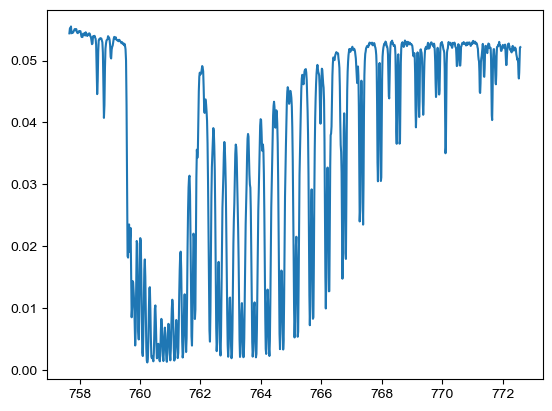

In [20]:
plt.plot(o1.wvl[9,0,:], o1.l1b[9,0,:])
print(cld_array[9, 0, 0])

In [232]:
ind_759 = np.argmin(np.abs(759-o1.wvl[9,0,:]))
ind_764 = np.argmin(np.abs(764-o1.wvl[9,0,:]))


ind_771 = np.argmin(np.abs(771-o1.wvl[9,0,:]))

In [238]:
R_list, slope_list = [], []

for i in range(39):
    for j in range(8):
        R = (o1.l1b[i,j,ind_759]-o1.l1b[i,j,ind_764])/(o1.l1b[i,j,ind_759]-o1.l1b[i,j,ind_771])
        if R > -1000 and R<500:
            R_list.append(R)
            slope_list.append(o1.slope_1km[i,j,0])

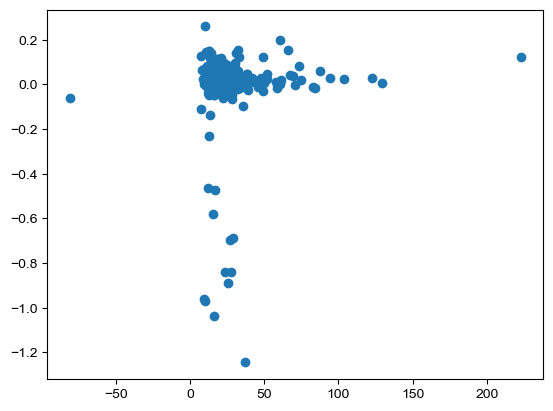

In [239]:
plt.scatter(R_list, slope_list)

In [25]:
class sat_tmp:

    def __init__(self, data):

        self.data = data

cldfile = '../simulation/data/20181018_central_asia_2_470cloud_test_20181018/pre-data.h5'
data = {}
f = h5py.File(cldfile, 'r')
data['lon_2d'] = dict(name='Gridded longitude'               , units='degrees'    , data=f['lon'][...])
data['lat_2d'] = dict(name='Gridded latitude'                , units='degrees'    , data=f['lat'][...])
data['cot_2d'] = dict(name='Gridded cloud optical thickness' , units='N/A'        , data=f[f'mod/cld/cot_ipa'][...])
data['cer_2d'] = dict(name='Gridded cloud effective radius'  , units='micro'      , data=f[f'mod/cld/cer_ipa'][...])
data['cth_2d'] = dict(name='Gridded cloud top height'        , units='km'         , data=f[f'mod/cld/cth_ipa'][...])
f.close()


#modl1b    = pre_cld(sat, tag, cth=cth, scale_factor=scale_factor, solver=solver, ref_threshold=ref_threshold)
modl1b    =  sat_tmp(data)

In [23]:
modl1b.data['cth_2d']['data'].shape

(242, 302)

In [24]:
(o1.lon2d).shape

(242, 302)

In [26]:
def rgb2hsv(rgb):
    """ convert RGB to HSV color space

    :param rgb: np.ndarray
    :return: np.ndarray
    """

    rgb = rgb.astype('float')
    maxv = np.amax(rgb, axis=2)
    maxc = np.argmax(rgb, axis=2)
    minv = np.amin(rgb, axis=2)
    minc = np.argmin(rgb, axis=2)

    hsv = np.zeros(rgb.shape, dtype='float')
    hsv[maxc == minc, 0] = np.zeros(hsv[maxc == minc, 0].shape)
    hsv[maxc == 0, 0] = (((rgb[..., 1] - rgb[..., 2]) * 60.0 / (maxv - minv + np.spacing(1))) % 360.0)[maxc == 0]
    hsv[maxc == 1, 0] = (((rgb[..., 2] - rgb[..., 0]) * 60.0 / (maxv - minv + np.spacing(1))) + 120.0)[maxc == 1]
    hsv[maxc == 2, 0] = (((rgb[..., 0] - rgb[..., 1]) * 60.0 / (maxv - minv + np.spacing(1))) + 240.0)[maxc == 2]
    hsv[maxv == 0, 1] = np.zeros(hsv[maxv == 0, 1].shape)
    hsv[maxv != 0, 1] = (1 - minv / (maxv + np.spacing(1)))[maxv != 0]
    hsv[..., 2] = maxv

    return hsv

mod_rgb = mpimg.imread(png[0])
wesn = png[1]
lon_rgb0 = np.linspace(wesn[0], wesn[1], mod_rgb.shape[1]+1)
lat_rgb0 = np.linspace(wesn[2], wesn[3], mod_rgb.shape[0]+1)
lon_rgb = (lon_rgb0[1:]+lon_rgb0[:-1])/2.0
lat_rgb = (lat_rgb0[1:]+lat_rgb0[:-1])/2.0

lon_rgb_2d, lat_rgb_2d = np.meshgrid(lon_rgb, lat_rgb[::-1], indexing='xy')

mod_r = mod_rgb[:, :, 0]
mod_g = mod_rgb[:, :, 1]
mod_b = mod_rgb[:, :, 2]
mod_hsv = rgb2hsv(mod_rgb[:,:,:3])
mod_h = mod_hsv[:, :, 0]
mod_s = mod_hsv[:, :, 1]
mod_v = mod_hsv[:, :, 2]
mod_v_over_s = mod_v/mod_s


logic_rgb_nan0 = np.logical_or(mod_v<=0.52, mod_s>0.17)

logic_rgb_nan = np.flipud(logic_rgb_nan0).T

x0_rgb = lon_rgb[0]
y0_rgb = lat_rgb[0]
dx_rgb = lon_rgb[1] - x0_rgb
dy_rgb = lat_rgb[1] - y0_rgb

lon_2d, lat_2d = o1.lon2d[:-2:3, :-1:3], o1.lat2d[:-2:3, :-1:3]
indices_x = np.int_(np.round((lon_2d-x0_rgb)/dx_rgb, decimals=0))
indices_y = np.int_(np.round((lat_2d-y0_rgb)/dy_rgb, decimals=0))
indices_x[indices_x>=943] = 942
indices_y[indices_y>=1386] = 1385


print(logic_rgb_nan.shape)
logic_ref_nan = logic_rgb_nan[indices_x, indices_y]

indices    = np.where(logic_ref_nan!=1)
indices_x  = indices[0]
indices_y  = indices[1]
lon = lon_2d[indices_x, indices_y]
lat = lat_2d[indices_x, indices_y]

cloud = np.zeros_like(o1.lon2d[:-2:3, :-1:3])
cloud[indices_x, indices_y] = 1


cld_X, cld_Y = np.where(cloud==1)[0], np.where(cloud==1)[1]
cld_position = []
for i in range(len(cld_X)):
    cld_position.append(np.array([cld_X[i], cld_Y[i]]))
cld_position = np.array(cld_position)

(1108, 1386)


In [27]:
lon_cld, lat_cld = modl1b.data['lon_2d']['data'], modl1b.data['lat_2d']['data']
cld_list = modl1b.data['cth_2d']['data']>0
cld_list_stripe = cld_list[:-2:3, :-1:3]
lon = lon_2d[cld_list_stripe==True]
lat = lat_2d[cld_list_stripe==True]
cld_X, cld_Y = np.where(cld_list_stripe==1)[0], np.where(cld_list_stripe==1)[1]
cld_position = []
for i in range(len(cld_X)):
    cld_position.append(np.array([cld_X[i], cld_Y[i]]))
cld_position = np.array(cld_position)

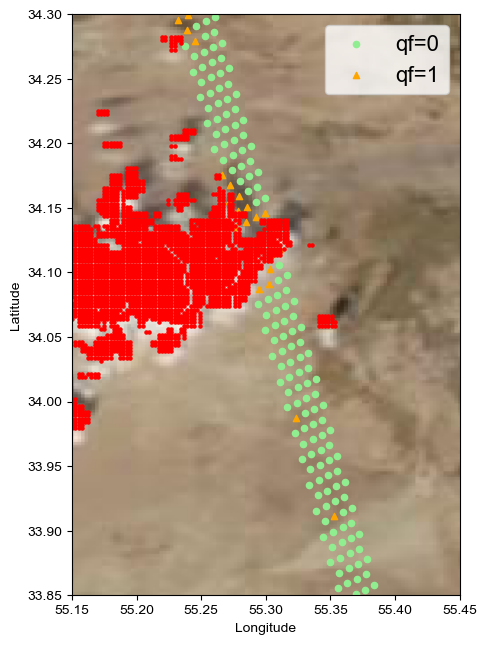

In [28]:
f,frame=plt.subplots(figsize=(5, 20))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
frame.scatter(qf_lon.flatten()[qf_array[:, :, 0].flatten()==0], qf_lat.flatten()[qf_array[:, :, 0].flatten()==0], s=20,
              marker='o', color='lightgreen', label='qf=0')
frame.scatter(qf_lon.flatten()[qf_array[:, :, 0].flatten()==1], qf_lat.flatten()[qf_array[:, :, 0].flatten()==1], s=20,
              marker='^', color='orange', label='qf=1')
frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [30]:
o1.lon.shape

(39, 8)

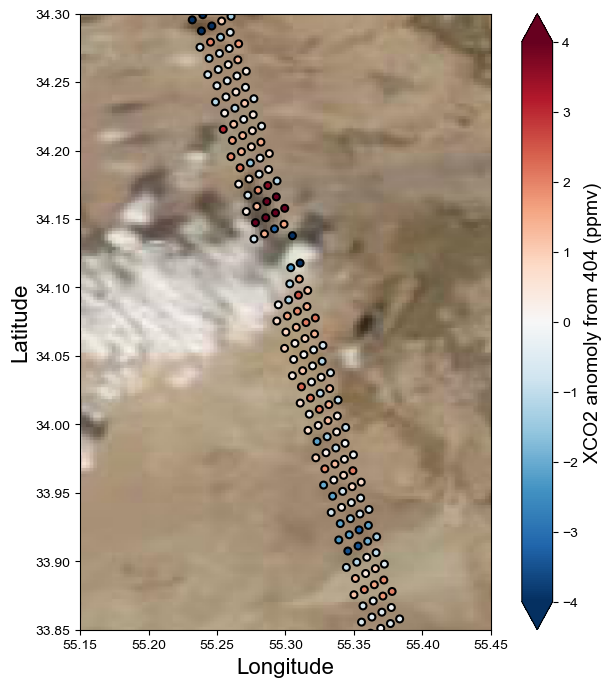

In [29]:
f,frame=plt.subplots(figsize=(8, 8))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
anomaly = 404
c = frame.scatter(o1.lon.flatten(), o1.lat.flatten(),
              s=25, c=o1.co2.flatten()*1e6-anomaly,
                  vmin=-4, vmax=4,
              marker='o', edgecolors='k', linewidths=1.5, cmap='RdBu_r')
cbar = f.colorbar(c, extend='both')
cbar.set_label(f'XCO2 anomoly from {anomaly} (ppmv)', fontsize=14)
#frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
#frame.legend(fontsize=16, facecolor='white')
frame.set_xlabel('Longitude', fontsize=16)
frame.set_ylabel('Latitude', fontsize=16)

plt.show()

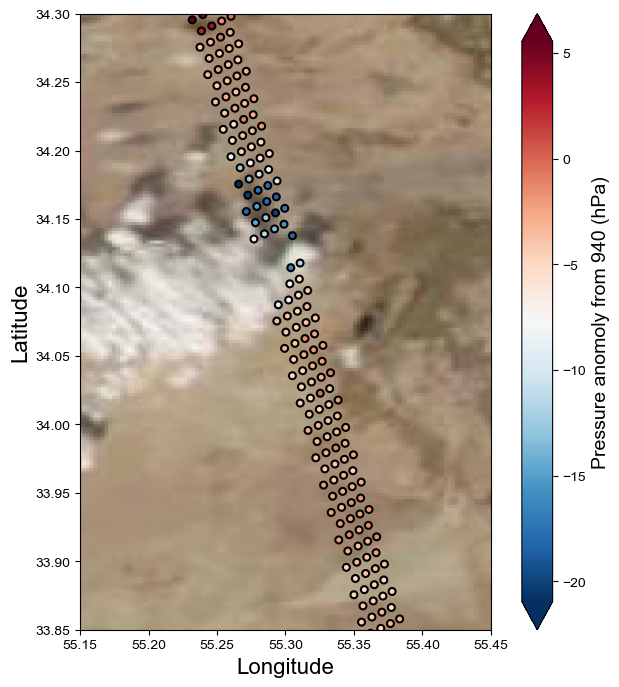

In [39]:
f,frame=plt.subplots(figsize=(8, 8))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
anomaly = 940
c = frame.scatter(o1.lon.flatten(), o1.lat.flatten(),
              s=25, c=o1.psur/100-anomaly,
                  #vmin=-4, vmax=4,
              marker='o', edgecolors='k', linewidths=1.5, cmap='RdBu_r')
cbar = f.colorbar(c, extend='both')
cbar.set_label(f'Pressure anomoly from {anomaly} (hPa)', fontsize=14)
#frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
#frame.legend(fontsize=16, facecolor='white')
frame.set_xlabel('Longitude', fontsize=16)
frame.set_ylabel('Latitude', fontsize=16)

plt.show()

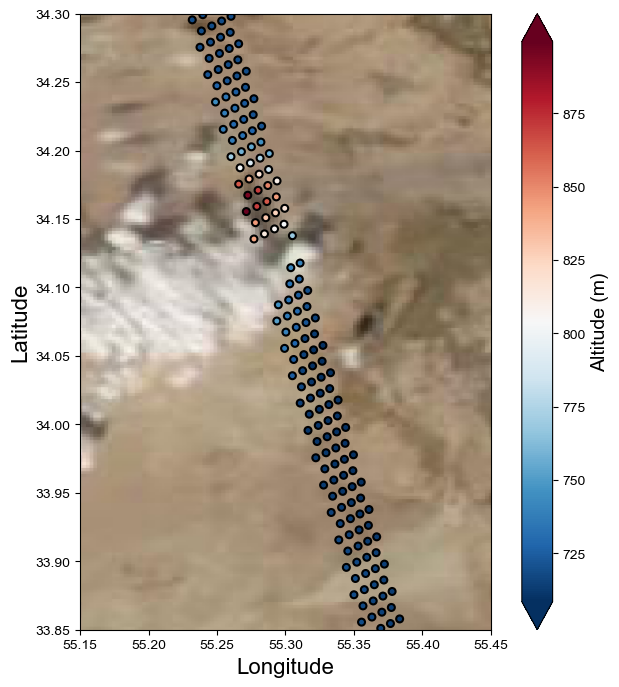

In [31]:
f,frame=plt.subplots(figsize=(8, 8))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
anomaly = 930
c = frame.scatter(o1.lon.flatten(), o1.lat.flatten(),
              s=25, c=alt_array.flatten(),
                  #vmin=-4, vmax=4,
              marker='o', edgecolors='k', linewidths=1.5, cmap='RdBu_r')
cbar = f.colorbar(c, extend='both')
cbar.set_label(f'Altitude (m)', fontsize=14)
#frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
#frame.legend(fontsize=16, facecolor='white')
frame.set_xlabel('Longitude', fontsize=16)
frame.set_ylabel('Latitude', fontsize=16)

plt.show()

In [30]:
cloud_dist = np.zeros_like(o1.slope_1km_all[:,:,0])
for j in range(cloud_dist.shape[1]):
    for i in range(cloud_dist.shape[0]):
        if cld_list_stripe[i, j] == 1:
            cloud_dist[i, j] = 0
        else:
            min_ind = np.argmin(np.sqrt(np.sum((cld_position-np.array([i, j]))**2, axis=1)))
            #print(min_ind)
            #print(cld_position[min_ind])
            cld_x, cld_y = cld_position[min_ind][0], cld_position[min_ind][1]
            dist = geopy.distance.distance((o1.lat2d[cld_x, cld_y], o1.lon2d[cld_x, cld_y]), (o1.lat2d[i, j], o1.lon2d[i, j])).km
            #print(dist)
            cloud_dist[i, j] = dist


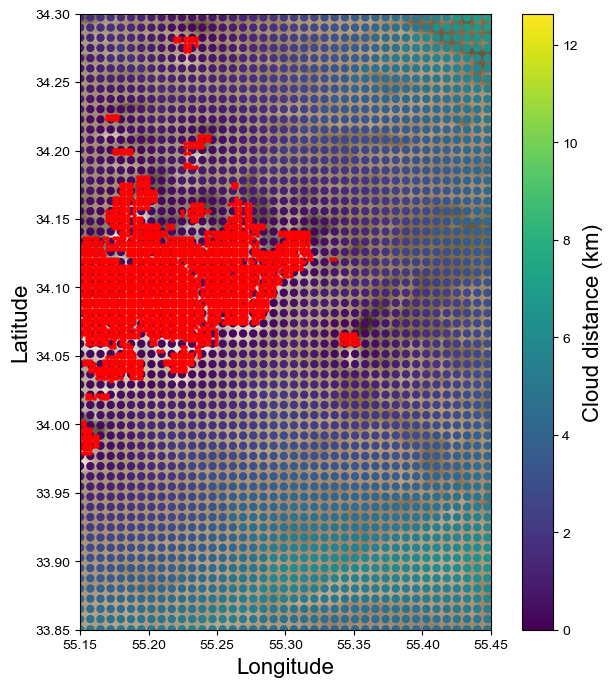

In [31]:
f,frame=plt.subplots(figsize=(8, 8))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
#frame.scatter(qf_lon.flatten()[qf_array[:, :, 0].flatten()==0], qf_lat.flatten()[qf_array[:, :, 0].flatten()==0], s=20,
#              marker='o', color='lightgreen', label='qf=0')
#frame.scatter(qf_lon.flatten()[qf_array[:, :, 0].flatten()==1], qf_lat.flatten()[qf_array[:, :, 0].flatten()==1], s=20,
#              marker='^', color='orange', label='qf=1')
#frame.scatter(lon, lat, s=5, color='r')
c = frame.scatter(o1.lon2d[:-2:3, :-2:3].flatten(), o1.lat2d[:-2:3, :-2:3].flatten(), s=25, c=cloud_dist.flatten())#, cmap='jet')
frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')


#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
cbar = f.colorbar(c)
cbar.set_label('Cloud distance (km)', fontsize=16)
#plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)

plt.show()

In [32]:
output = np.array([o1.lon2d[:-2:3, :-2:3], o1.lat2d[:-2:3, :-2:3], cloud_dist, 
                   o1.slope_1km_all[:,:,0], o1.inter_1km_all[:,:,0],
                   o2.slope_1km_all[:,:,0], o2.inter_1km_all[:,:,0],
                   o3.slope_1km_all[:,:,0], o3.inter_1km_all[:,:,0],
                   o1.rad_1km_c3d_all[:,:,-1], o1.rad_1km_clr_all[:,:,-1],
                   o2.rad_1km_c3d_all[:,:,-1], o2.rad_1km_clr_all[:,:,-1],
                   o3.rad_1km_c3d_all[:,:,-1], o3.rad_1km_clr_all[:,:,-1],
                   ])
cld_slope_inter = pd.DataFrame(output.reshape(output.shape[0], output.shape[1]*output.shape[2]).T,
                               columns=['lon', 'lat', 'cld_dis', 
                                        'o2a_slope', 'o2a_inter', 
                                        'wco2_slope', 'wco2_inter', 
                                        'sco2_slope', 'sco2_inter',
                                        'o2a_continuum_3d', 'o2a_continuum_clr',
                                        'wco2_continuum_3d', 'wco2_continuum_clr',
                                        'sco2_continuum_3d', 'sco2_continuum_clr',])

cld_slope_inter.to_pickle('cld_slope_inter_central_asia_20181018_2_test_basic.pkl')

print(cld_slope_inter.shape)

(8000, 15)


In [36]:
o1.lon2d[:-2:3, :-1:3].shape

(113, 160)

In [115]:
cloud_dist.shape

(160, 207)

In [116]:
o1.slope_1km_all.shape

(160, 207, 2)

In [36]:
def heatmap_xy(x, y, ax):
    from matplotlib.colors import LogNorm
    light_jet = cmap_map(lambda x: x/3*2 + 0.33, cm.jet)
    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x, y = x[mask], y[mask]
    # Calculate the point density
    data , x_e, y_e = np.histogram2d(x, y, bins=15)#, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    z[np.where(np.isinf(z))] = np.nanmax(z)
    z[np.where(z<0)] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    plot_x, plot_y, z = np.array(x)[idx], np.array(y)[idx], z[idx]
    #ax.scatter(plot_x, plot_y, c=z, s=15*z/np.nanmax(z), cmap=light_jet)
    ax.scatter(plot_x, plot_y, s=3, c='k')
    #ax.hist2d(plot_x, plot_y, bins=50, norm=LogNorm())
    out = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    sns.kdeplot(out, x='x', y='y', cmap='hot_r', n_levels=20, fill=True, ax=ax, alpha=0.65)
    return plot_x, plot_y, z

In [37]:
"""def heatmap_xy(x, y, ax):
    from matplotlib.colors import LogNorm
    light_jet = cmap_map(lambda x: x/3*2 + 0.33, cm.jet)
    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x, y = x[mask], y[mask]
    # Calculate the point density
    data , x_e, y_e = np.histogram2d(x, y, bins=15)#, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    z[np.where(np.isinf(z))] = np.nanmax(z)
    z[np.where(z<0)] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    plot_x, plot_y, z = np.array(x)[idx], np.array(y)[idx], z[idx]
    #ax.scatter(plot_x, plot_y, c=z, s=15*z/np.nanmax(z), cmap=light_jet)
    #ax.scatter(plot_x, plot_y, s=3, c='k')
    ax.hist2d(plot_x, plot_y, bins=150, norm=LogNorm(), cmap=light_jet)
    #out = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    #sns.kdeplot(out, x='x', y='y', cmap='hot_r', n_levels=20, fill=True, ax=ax, alpha=0.65)
    return plot_x, plot_y, z"""

'def heatmap_xy(x, y, ax):\n    from matplotlib.colors import LogNorm\n    light_jet = cmap_map(lambda x: x/3*2 + 0.33, cm.jet)\n    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))\n    x, y = x[mask], y[mask]\n    # Calculate the point density\n    data , x_e, y_e = np.histogram2d(x, y, bins=15)#, density=True)\n    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)\n    z[np.where(np.isnan(z))] = 0.0\n    z[np.where(np.isinf(z))] = np.nanmax(z)\n    z[np.where(z<0)] = 0.0\n    # Sort the points by density, so that the densest points are plotted last\n    idx = z.argsort()\n    plot_x, plot_y, z = np.array(x)[idx], np.array(y)[idx], z[idx]\n    #ax.scatter(plot_x, plot_y, c=z, s=15*z/np.nanmax(z), cmap=light_jet)\n    #ax.scatter(plot_x, plot_y, s=3, c=\'k\')\n    ax.hist2d(plot_x, plot_y, bins=150, norm=LogNorm(), cmap=light_jet)\n    #out = pd.DataFrame(np.array([x, y]).T, columns=[\'x\',

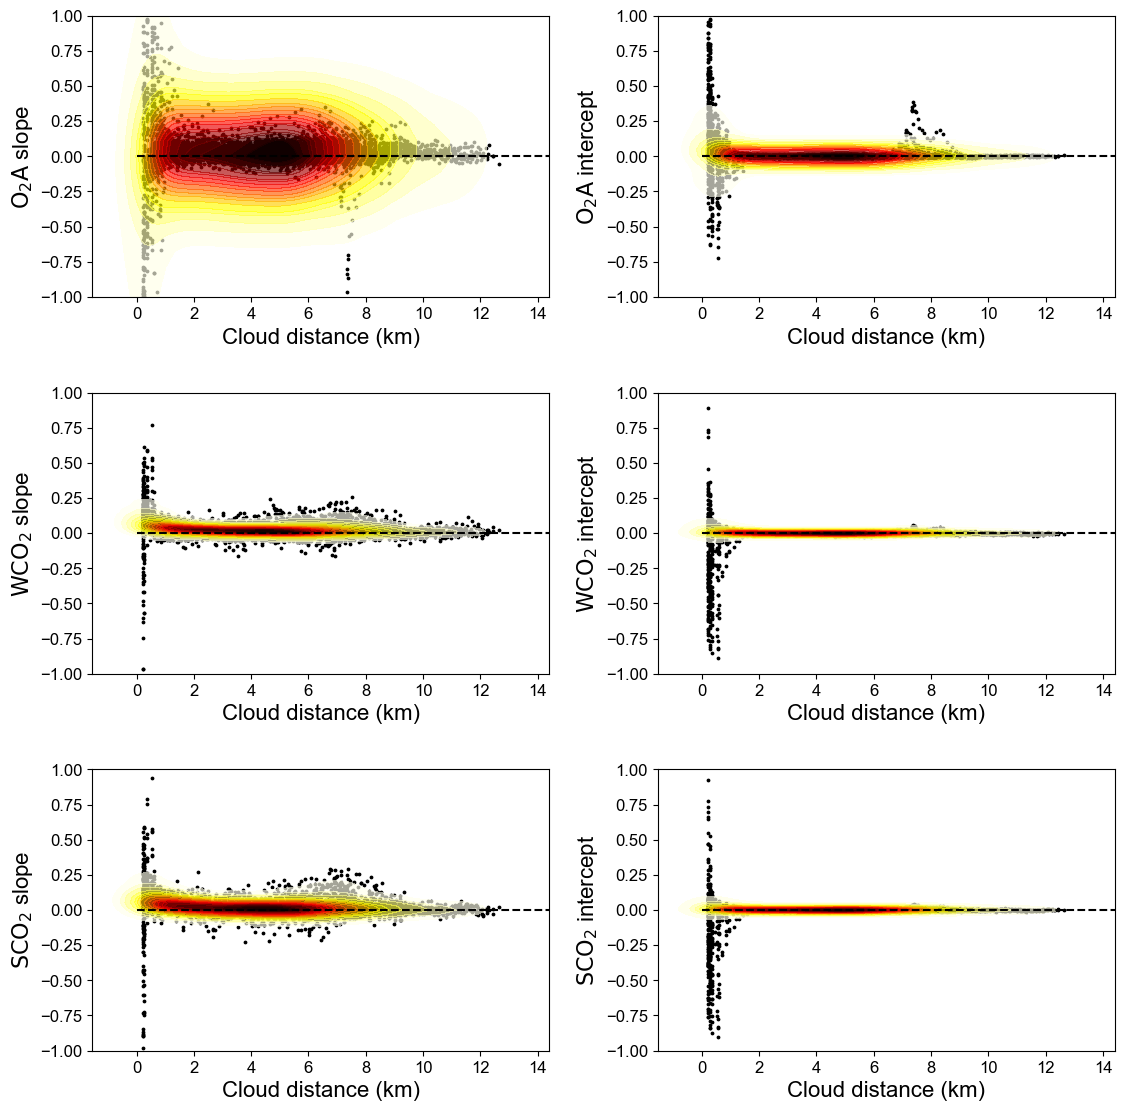

In [38]:
fig, ((ax11, ax12), 
      (ax21, ax22),
      (ax31, ax32)) = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.tight_layout(pad=5.0)
label_size = 16
tick_size = 12
mask = cloud_dist > 0
heatmap_xy(cloud_dist[mask], o1.slope_1km_all[:,:,0][mask], ax11)
heatmap_xy(cloud_dist[mask], o1.inter_1km_all[:,:,0][mask], ax12)
heatmap_xy(cloud_dist[mask], o2.slope_1km_all[:,:,0][mask], ax21)
heatmap_xy(cloud_dist[mask], o2.inter_1km_all[:,:,0][mask], ax22)
heatmap_xy(cloud_dist[mask], o3.slope_1km_all[:,:,0][mask], ax31)
heatmap_xy(cloud_dist[mask], o3.inter_1km_all[:,:,0][mask], ax32)

for ax in [ax11, ax21, ax31, ax12, ax22, ax32]:
    ax.set_xlabel('Cloud distance (km)', fontsize=label_size)
    ax.tick_params(axis='both', labelsize=tick_size)
    _, xmax = ax.get_xlim()
    ax.hlines(0, 0, xmax, linestyle='--', color='k')

ax11.set_ylabel('$\mathrm{O_2A}$ slope', fontsize=label_size)
ax12.set_ylabel('$\mathrm{O_2A}$ intercept', fontsize=label_size)
ax21.set_ylabel('$\mathrm{WCO_2}$ slope', fontsize=label_size)
ax22.set_ylabel('$\mathrm{WCO_2}$ intercept', fontsize=label_size)
ax31.set_ylabel('$\mathrm{SCO_2}$ slope', fontsize=label_size)
ax32.set_ylabel('$\mathrm{SCO_2}$ intercept', fontsize=label_size)


for ax in [ax11, ax21, ax31]:
    ax.set_ylim(-1, 1)
    
for ax in [ax12, ax22, ax32]:
    ax.set_ylim(-1, 1)
#ax.plot([20, 20], [0, 1.1], 'r')
#ax.plot([400, 400], [0, 1.1], 'r')
#ax.set_ylim(0, 1.1)
#ax.fill_between(t[2:41]*1e9, intensity[2:41], 0, color='lightgrey', interpolate=True)
#I0 = quad(intensity_fxn, 20e-9, 400e-9, args=(decay_const))[0]

#ax.set_yscale('log')
#fig.savefig('Q2.1-2.png', dpi=150, bbox_inches='tight')
plt.show()

In [40]:
def heatmap_xy_2(x, y, ax):
    light_jet = cmap_map(lambda x: x/3*2 + 0.33, cm.jet)
    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x, y = x[mask], y[mask]
    # Calculate the point density
    
    interval = 1/1
    start = 0.25
    cld_levels = np.arange(start, 15, interval)
    value_avg, value_std = np.zeros(len(cld_levels)-1), np.zeros(len(cld_levels)-1)
    for i in range(len(cld_levels)-1):
        select = np.logical_and(x>=cld_levels[i], x < cld_levels[i+1])
        if select.sum()>0:
            #value_avg[i] = np.nanmean(y[select])
            #value_std[i] = np.nanstd(y[select])
            value_avg[i] = np.percentile(y[select], 50)
            value_std[i] = np.percentile(y[select], 75)-np.percentile(y[select], 25)
        else:
            value_avg[i] = np.nan
            value_std[i] = np.nan
    cld_list = (cld_levels[:-1] + cld_levels[1:])/2
    ax.scatter(x[x<start], y[x<start], s=1, color='lightgrey')
    ax.scatter(x[x>=start], y[x>=start], s=1, color='k')
    ax.errorbar(cld_list, value_avg, yerr=value_std, 
                marker='s', color='r', linewidth=2, linestyle='')#light_jet)
    
    val_mask = ~(np.isnan(value_avg) | np.isnan(value_std) | np.isinf(value_avg) | np.isinf(value_std))
    print(value_avg[val_mask])
    print(value_std[val_mask])
    popt, pcov = curve_fit(func, cld_list[val_mask], value_avg[val_mask], bounds=([-2, 0.], [2, 10,]),
                           p0=(0.1, 0.7),
                           maxfev=3000,
                           #sigma=value_std[val_mask], 
                           #absolute_sigma=True,
                          )

    ax.plot(cld_list, func(cld_list, *popt), '--', color='orange', 
              label='fit: a=%5.3f, b=%5.3f' % tuple(popt), linewidth=3.5)
    
    #ax.plot(cld_list, func(cld_list, 1, 2), '--', color='green',)
    #ax.plot(cld_list, func(cld_list, 0.2, 1), '--', color='cyan',)
    ax.legend()
    return None#XX, YY, heatmap

from  scipy.optimize import curve_fit

def func(x, a, b):
     return a * np.exp(-b * x)

[0.04642501 0.03724593 0.02919317 0.02506577 0.02763759 0.02975771
 0.03268747 0.03244074 0.04059903 0.03929591 0.02124176 0.01108896
 0.00805219]
[0.17608362 0.05369331 0.04050128 0.04449993 0.04803073 0.05352539
 0.0597117  0.06988215 0.05323582 0.04451982 0.0421368  0.05265202
 0.02906192]
[ 0.01751573  0.00504991  0.00167734  0.00160298  0.00104581  0.00106015
  0.00176028  0.00205703  0.00240528 -0.00050471  0.00287982  0.00417574
  0.00405319]
[0.05116593 0.00741158 0.00621146 0.00637808 0.00676222 0.006887
 0.00819521 0.01095228 0.00797164 0.00613549 0.00532771 0.00552745
 0.00209929]
[0.05285289 0.02704672 0.01962164 0.01732514 0.0141481  0.01375269
 0.01934287 0.01809111 0.01788683 0.00573786 0.00982556 0.01661898
 0.01615489]
[0.05597493 0.03513581 0.03412764 0.03436898 0.03530828 0.04178274
 0.0472306  0.05384171 0.04833668 0.03072064 0.03511841 0.03608627
 0.01293489]
[ 1.01193087e-02  1.12392742e-03 -1.03249055e-03 -1.58357849e-03
 -1.27946328e-03 -1.05995043e-03 -6.177545

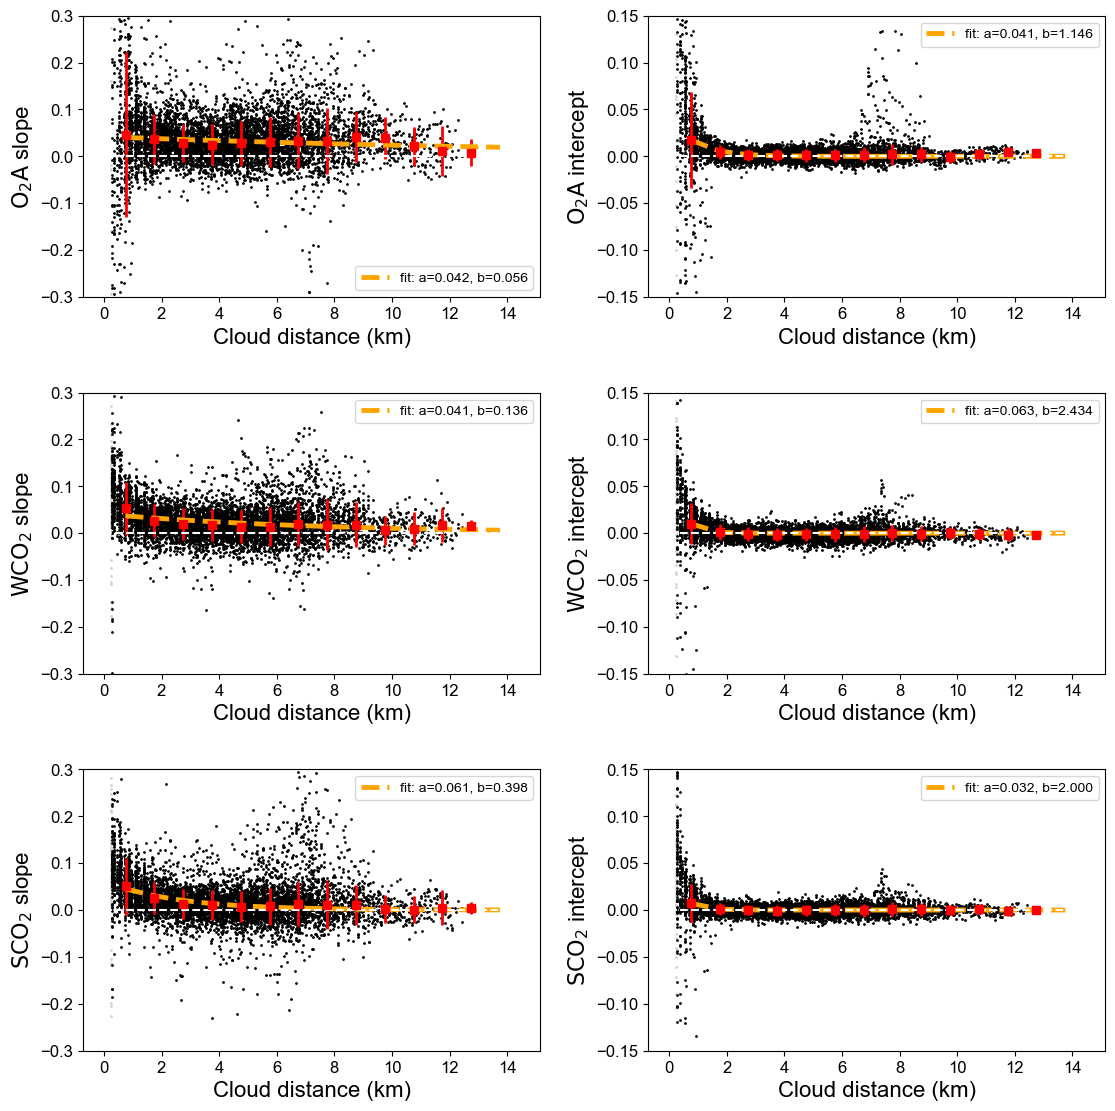

In [42]:
fig, ((ax11, ax12), 
      (ax21, ax22),
      (ax31, ax32)) = plt.subplots(3, 2, figsize=(12, 12), sharex=False)
fig.tight_layout(pad=5.0)
label_size = 16
tick_size = 12
mask = cloud_dist > 0
mask = np.logical_and(cloud_dist > 0, o1.rad_1km_c3d_all[:,:,-1]>o1.rad_1km_clr_all[:,:,-1])

#"""
heatmap_xy_2(cloud_dist[mask], o1.slope_1km_all[:,:,0][mask], ax11)
heatmap_xy_2(cloud_dist[mask], o1.inter_1km_all[:,:,0][mask], ax12)
heatmap_xy_2(cloud_dist[mask], o2.slope_1km_all[:,:,0][mask], ax21)
heatmap_xy_2(cloud_dist[mask], o2.inter_1km_all[:,:,0][mask], ax22)
heatmap_xy_2(cloud_dist[mask], o3.slope_1km_all[:,:,0][mask], ax31)
heatmap_xy_2(cloud_dist[mask], o3.inter_1km_all[:,:,0][mask], ax32)
#"""


#popt, pcov = curve_fit(func, cloud_dist[mask], o1.slope_1km_all[:,:,0][mask])#, bounds=(0, [3., 1., 0.5]))

#ax11.plot(cloud_dist[mask], func(cloud_dist[mask], *popt), 'r--',
#          label='fit: a=%5.3f, b=%5.3ff' % tuple(popt))


"""
ax11.scatter(cloud_dist[mask], o1.slope_1km_all[:,:,0][mask])
ax12.scatter(cloud_dist[mask], o1.inter_1km_all[:,:,0][mask])
ax21.scatter(cloud_dist[mask], o2.slope_1km_all[:,:,0][mask])
ax22.scatter(cloud_dist[mask], o2.inter_1km_all[:,:,0][mask])
ax31.scatter(cloud_dist[mask], o3.slope_1km_all[:,:,0][mask])
ax32.scatter(cloud_dist[mask], o3.inter_1km_all[:,:,0][mask])
#"""
for ax in [ax11, ax21, ax31, ax12, ax22, ax32]:
    ax.set_xlabel('Cloud distance (km)', fontsize=label_size)
    ax.tick_params(axis='both', labelsize=tick_size)
    _, xmax = ax.get_xlim()
    ax.hlines(0, 0, xmax, linestyle='--', color='white')
    
ax11.set_ylabel('$\mathrm{O_2A}$ slope', fontsize=label_size)
ax12.set_ylabel('$\mathrm{O_2A}$ intercept', fontsize=label_size)
ax21.set_ylabel('$\mathrm{WCO_2}$ slope', fontsize=label_size)
ax22.set_ylabel('$\mathrm{WCO_2}$ intercept', fontsize=label_size)
ax31.set_ylabel('$\mathrm{SCO_2}$ slope', fontsize=label_size)
ax32.set_ylabel('$\mathrm{SCO_2}$ intercept', fontsize=label_size)

limit_1 = 0.3
limit_2 = 0.15
for ax in [ax11, ax21, ax31]:
    ax.set_ylim(-limit_1, limit_1)
    
for ax in [ax12, ax22, ax32]:
    ax.set_ylim(-limit_2, limit_2)

#ax.plot([20, 20], [0, 1.1], 'r')
#ax.plot([400, 400], [0, 1.1], 'r')
#ax.set_ylim(0, 1.1)
#ax.fill_between(t[2:41]*1e9, intensity[2:41], 0, color='lightgrey', interpolate=True)
#I0 = quad(intensity_fxn, 20e-9, 400e-9, args=(decay_const))[0]

#ax.set_yscale('log')
#fig.savefig('Q2.1-2.png', dpi=150, bbox_inches='tight')
plt.show()

(312,) (39, 8)


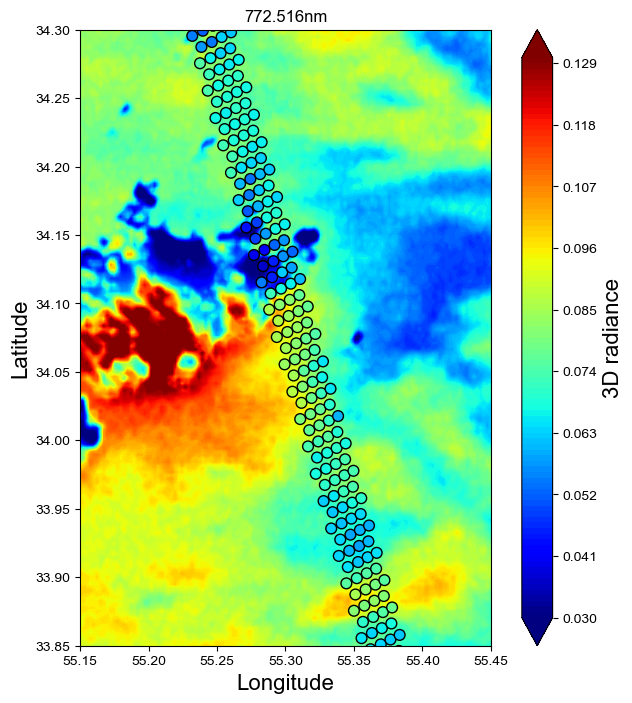

In [47]:


#f, (ax1, ax2, ax3)=plt.subplots(1, 3, figsize=(24, 8))
f, ax1=plt.subplots(1, 1, figsize=(8, 8))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
for ax in (ax1, ax2, ax3):
    ax.imshow(img,extent=wesn)
    ax.set_xlim(np.min(lon_dom), np.max(lon_dom))
    ax.set_ylim(np.min(lat_dom), np.max(lat_dom))
    ax.set_xlabel('Longitude', fontsize=16)
    ax.set_ylabel('Latitude', fontsize=16)
mask = np.logical_or(qf_array[:, :, 0].flatten()==0, qf_array[:, :, 0].flatten()==1)
print(mask.shape, o1.lon.shape)



# ax1

vmax = 0.13
vmin = 0.03
lev = np.arange(vmin, vmax+1e-7, 0.001)
rad_to_plot = o1.rad_c3d[:,:,10].copy()
rad_to_plot[rad_to_plot>vmax] = vmax

l1b_lon, l1b_lat, l1b_continuum = [], [], []
for i in range(o1.lon.shape[0]):
    for j in range(o1.lon.shape[1]):
        l1b_lon.append(o1.lon[i, j])
        l1b_lat.append(o1.lat[i, j])
        l1b_continuum.append(o1.l1b[i, j, np.argmin(np.abs(o1.wvl[i, j, :]-o1.lam[10]))])
cc1 = ax1.contourf(o1.lon2d, o1.lat2d, rad_to_plot, lev, cmap='jet',
                   vmin=vmin, vmax=vmax, extend='both', alpha=1)

#frame.contour(l1b_860_lon_2d, l1b_860_lat_2d, rad_860_2d, lev, cmap='jet',
#                   vmin=vmin, vmax=vmax, extend='both')#, alpha=0.5)
mask = (o1.lat.flatten()*1e6)>0
ax1.scatter(np.array(l1b_lon)[mask], np.array(l1b_lat)[mask],
              c=np.array(l1b_continuum)[mask],
              s=60,
              cmap='jet',
              vmin=vmin, vmax=vmax,
              marker='o', edgecolors='k')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
cbar1 = f.colorbar(cc1, ax=ax1)#, extend='both')
cbar1.set_label('3D radiance', fontsize=16)
ax1.set_title(f'{o1.lam[10]:.3f}nm')



"""# ax2

vmax = 0.04
vmin = 0.0
lev = np.arange(vmin, vmax+1e-7, 0.0005)
rad_to_plot = o2.rad_c3d[:,:,10].copy()
rad_to_plot[rad_to_plot>vmax] = vmax

l1b_lon, l1b_lat, l1b_continuum = [], [], []
for i in range(o2.lon.shape[0]):
    for j in range(o2.lon.shape[1]):
        l1b_lon.append(o2.lon[i, j])
        l1b_lat.append(o2.lat[i, j])
        l1b_continuum.append(o2.l1b[i, j, np.argmin(np.abs(o2.wvl[i, j, :]-o2.lam[10]))])
cc2 = ax2.contourf(o2.lon2d, o2.lat2d, rad_to_plot, lev, cmap='jet',
                   vmin=vmin, vmax=vmax, extend='both', alpha=1)

#frame.contour(l1b_860_lon_2d, l1b_860_lat_2d, rad_860_2d, lev, cmap='jet',
#                   vmin=vmin, vmax=vmax, extend='both')#, alpha=0.5)
mask = (o2.lat.flatten()*1e6)>0
ax2.scatter(np.array(l1b_lon)[mask], np.array(l1b_lat)[mask],
              c=np.array(l1b_continuum)[mask],
              s=60,
              cmap='jet',
              vmin=vmin, vmax=vmax,
              marker='o', edgecolors='k')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
cbar2 = f.colorbar(cc2, ax=ax2)#, extend='both')
cbar2.set_label('3D radiance', fontsize=16)
ax2.set_title(f'{o2.lam[10]:.3f}nm')


# ax3

vmax = 0.01
vmin = 0.00
lev = np.arange(vmin, vmax+1e-7, 0.0001)
rad_to_plot = o3.rad_c3d[:,:,10].copy()
rad_to_plot[rad_to_plot>vmax] = vmax

l1b_lon, l1b_lat, l1b_continuum = [], [], []
for i in range(o1.lon.shape[0]):
    for j in range(o3.lon.shape[1]):
        l1b_lon.append(o3.lon[i, j])
        l1b_lat.append(o3.lat[i, j])
        l1b_continuum.append(o3.l1b[i, j, np.argmin(np.abs(o3.wvl[i, j, :]-o3.lam[10]))])
cc3 = ax3.contourf(o3.lon2d, o3.lat2d, rad_to_plot, lev, cmap='jet',
                   vmin=vmin, vmax=vmax, extend='both', alpha=1)

#frame.contour(l1b_860_lon_2d, l1b_860_lat_2d, rad_860_2d, lev, cmap='jet',
#                   vmin=vmin, vmax=vmax, extend='both')#, alpha=0.5)
mask = (o3.lat.flatten()*1e6)>0
ax3.scatter(np.array(l1b_lon)[mask], np.array(l1b_lat)[mask],
              c=np.array(l1b_continuum)[mask],
              s=60,
              cmap='jet',
              vmin=vmin, vmax=vmax,
              marker='o', edgecolors='k')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
cbar3 = f.colorbar(cc3, ax=ax3)#, extend='both')
cbar3.set_label('3D radiance', fontsize=16)
ax3.set_title(f'{o3.lam[10]:.3f}nm')"""



plt.show()

In [36]:
np.random.rand(5)

array([0.10063583, 0.89480544, 0.58371901, 0.42890508, 0.6721474 ])

In [39]:
i = np.random.rand(5)
j = np.random.rand(5)
o2a_l1b_mean_diff = i-np.mean(i)
o2a_sim_mean_diff = j-np.mean(j)
r_o2a = np.sum(o2a_l1b_mean_diff*o2a_sim_mean_diff)/\
                            np.sqrt(np.sum(o2a_l1b_mean_diff**2)*np.sum(o2a_sim_mean_diff**2))
print(r_o2a)
np.corrcoef(i, j)[0, 1]

0.4856310096328843


0.48563100963288436

(312,) (39, 8)


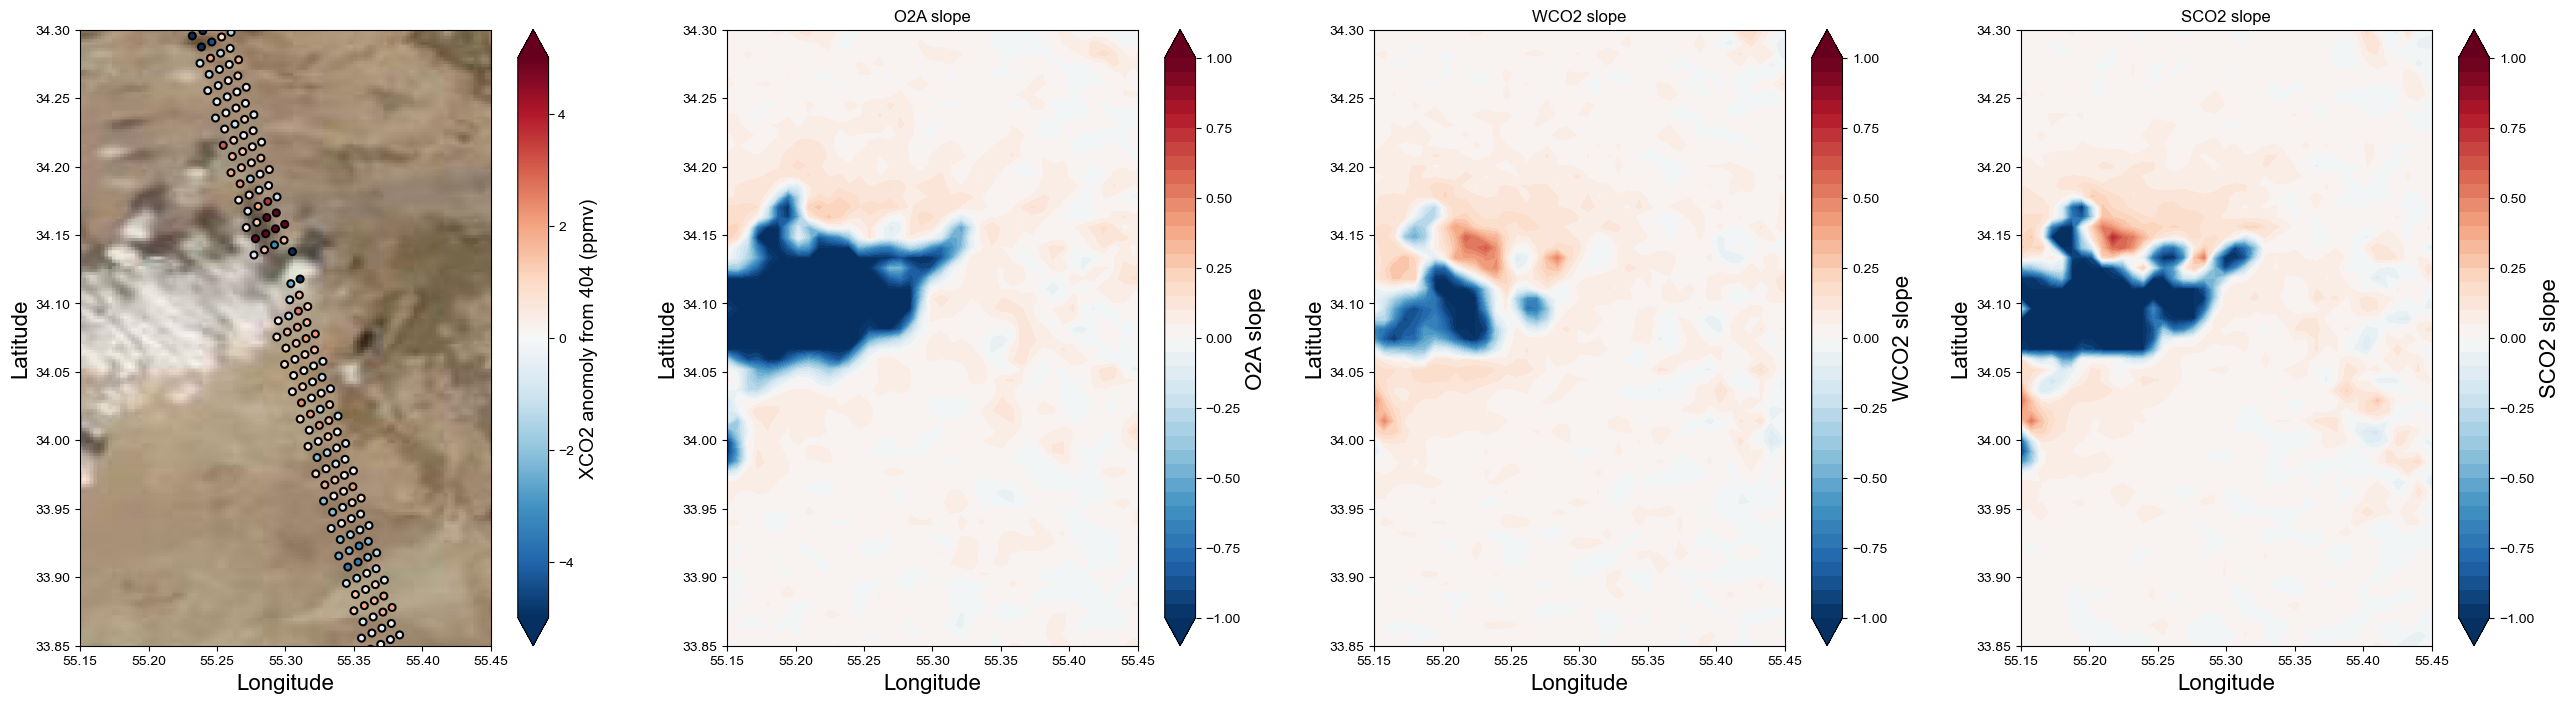

In [61]:


f, (ax0, ax1, ax2, ax3)=plt.subplots(1, 4, figsize=(32, 8))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
for ax in (ax0, ax1, ax2, ax3):
    ax.imshow(img,extent=wesn)
    ax.set_xlim(np.min(lon_dom), np.max(lon_dom))
    ax.set_ylim(np.min(lat_dom), np.max(lat_dom))
    ax.set_xlabel('Longitude', fontsize=16)
    ax.set_ylabel('Latitude', fontsize=16)
mask = np.logical_or(qf_array[:, :, 0].flatten()==0, qf_array[:, :, 0].flatten()==1)
print(mask.shape, o1.lon.shape)


# ax0

anomaly = 404
c = ax0.scatter(o1.lon.flatten(), o1.lat.flatten(),
              s=25, c=o1.co2.flatten()*1e6-anomaly,
                  vmin=-5, vmax=5,
              marker='o', edgecolors='k', linewidths=1.5, cmap='RdBu_r')
cbar = f.colorbar(c, extend='both', ax=ax0)
cbar.set_label(f'XCO2 anomoly from {anomaly} (ppmv)', fontsize=14)
#ax0.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')



# ax1

vmax = 1
vmin = -1
lev = np.arange(vmin, vmax+1e-7, 0.05)
rad_to_plot = o1.slope_1km_all[:,:,0].copy()
rad_to_plot[rad_to_plot>=vmax] = vmax
rad_to_plot[rad_to_plot<=vmin] = vmin

cc1 = ax1.contourf(o1.lon2d[:-2:3, :-2:3], o1.lat2d[:-2:3, :-2:3],  rad_to_plot, lev, cmap='RdBu_r',
                   vmin=vmin, vmax=vmax, extend='both', alpha=1)

cbar1 = f.colorbar(cc1, ax=ax1)
cbar1.set_label('O2A slope', fontsize=16)
ax1.set_title('O2A slope')



# ax2

rad_to_plot = o2.slope_1km_all[:,:,0].copy()
rad_to_plot[rad_to_plot>=vmax] = vmax
rad_to_plot[rad_to_plot<=vmin] = vmin

cc2 = ax2.contourf(o2.lon2d[:-2:3, :-2:3], o2.lat2d[:-2:3, :-2:3],  rad_to_plot, lev, cmap='RdBu_r',
                   vmin=vmin, vmax=vmax, extend='both', alpha=1)

cbar2 = f.colorbar(cc2, ax=ax2)
cbar2.set_label('WCO2 slope', fontsize=16)
ax2.set_title('WCO2 slope')


# ax3

rad_to_plot = o3.slope_1km_all[:,:,0].copy()
rad_to_plot[rad_to_plot>=vmax] = vmax
rad_to_plot[rad_to_plot<=vmin] = vmin

cc3 = ax3.contourf(o3.lon2d[:-2:3, :-2:3], o3.lat2d[:-2:3, :-2:3],  rad_to_plot, lev, cmap='RdBu_r',
                   vmin=vmin, vmax=vmax, extend='both', alpha=1)

cbar3 = f.colorbar(cc3, ax=ax3)
cbar3.set_label('SCO2 slope', fontsize=16)
ax3.set_title('SCO2 slope')



plt.show()

(312,) (39, 8)


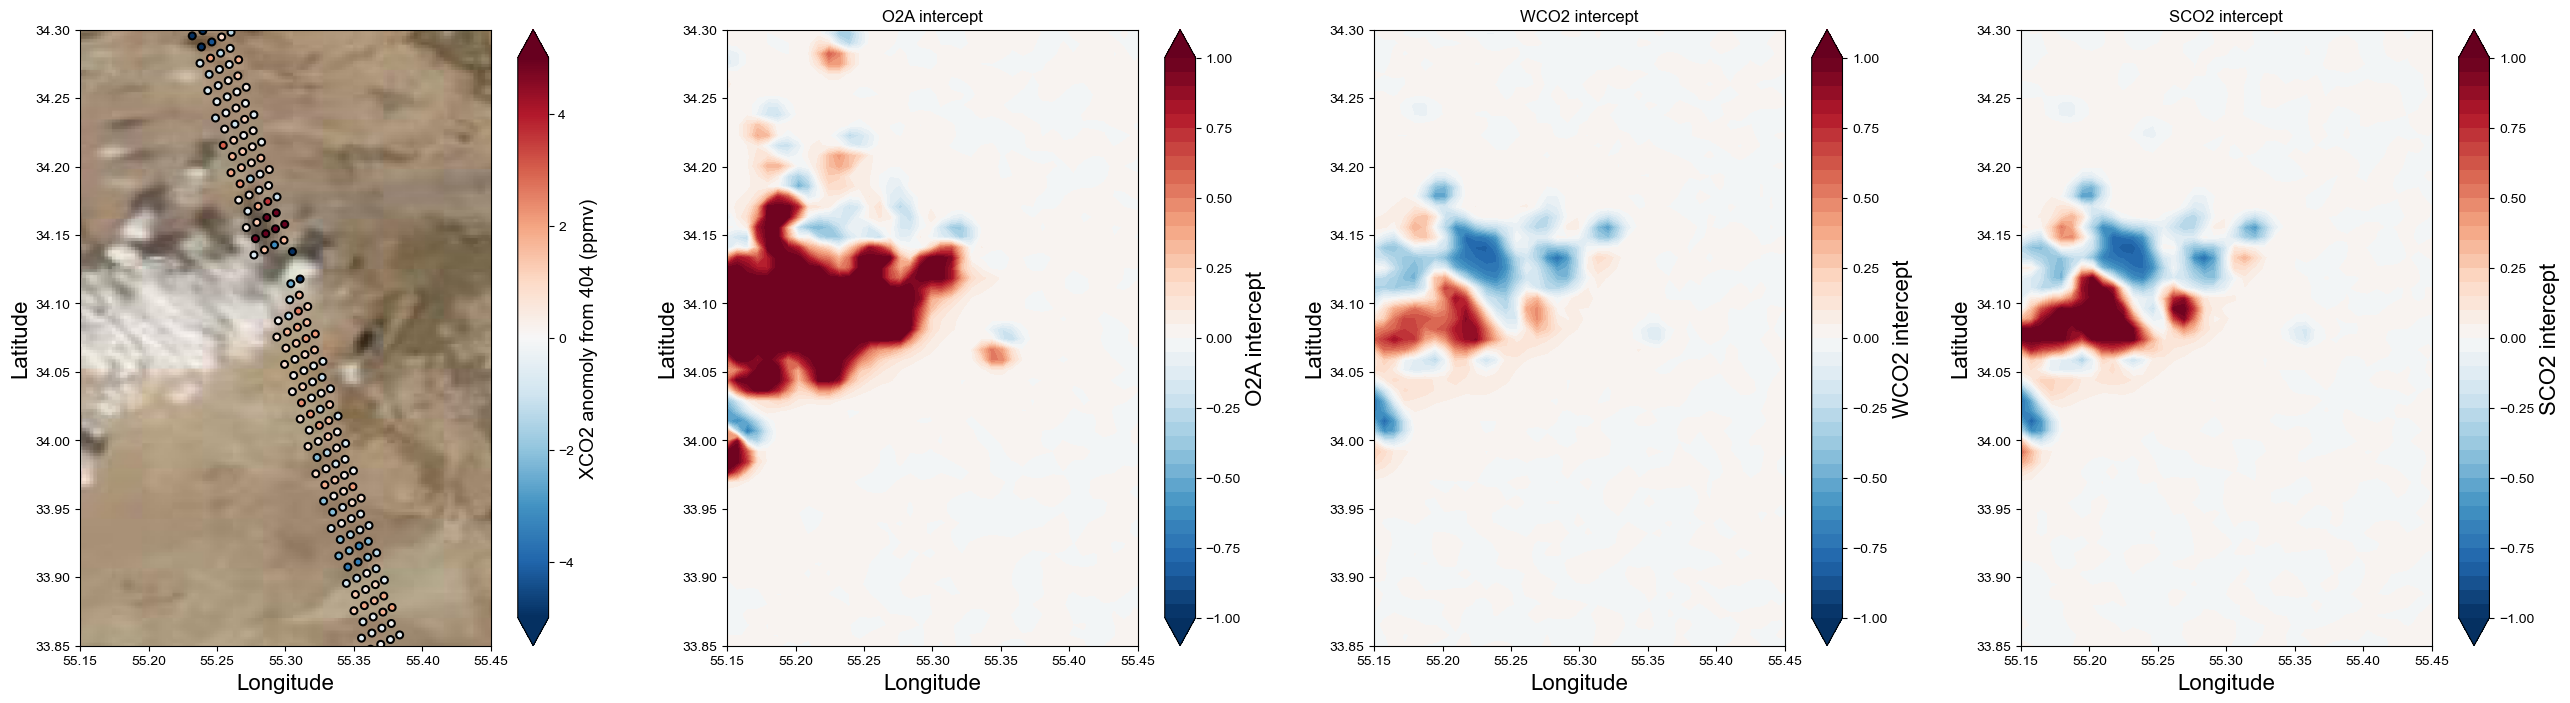

In [44]:


f, (ax0, ax1, ax2, ax3)=plt.subplots(1, 4, figsize=(32, 8))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
for ax in (ax0, ax1, ax2, ax3):
    ax.imshow(img,extent=wesn)
    ax.set_xlim(np.min(lon_dom), np.max(lon_dom))
    ax.set_ylim(np.min(lat_dom), np.max(lat_dom))
    ax.set_xlabel('Longitude', fontsize=16)
    ax.set_ylabel('Latitude', fontsize=16)
mask = np.logical_or(qf_array[:, :, 0].flatten()==0, qf_array[:, :, 0].flatten()==1)
print(mask.shape, o1.lon.shape)


# ax0

anomaly = 404
c = ax0.scatter(o1.lon.flatten(), o1.lat.flatten(),
              s=25, c=o1.co2.flatten()*1e6-anomaly,
                  vmin=-5, vmax=5,
              marker='o', edgecolors='k', linewidths=1.5, cmap='RdBu_r')
cbar = f.colorbar(c, extend='both', ax=ax0)
cbar.set_label(f'XCO2 anomoly from {anomaly} (ppmv)', fontsize=14)
#ax0.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')



# ax1

vmax = 1
vmin = -1
lev = np.arange(vmin, vmax+1e-7, 0.05)
rad_to_plot = o1.inter_1km_all[:,:,0].copy()
rad_to_plot[rad_to_plot>=vmax] = vmax
rad_to_plot[rad_to_plot<=vmin] = vmin

cc1 = ax1.contourf(o1.lon2d[:-2:3, :-2:3], o1.lat2d[:-2:3, :-2:3],  rad_to_plot, lev, cmap='RdBu_r',
                   vmin=vmin, vmax=vmax, extend='both', alpha=1)

cbar1 = f.colorbar(cc1, ax=ax1)
cbar1.set_label('O2A intercept', fontsize=16)
ax1.set_title('O2A intercept')



# ax2

rad_to_plot = o2.inter_1km_all[:,:,0].copy()
rad_to_plot[rad_to_plot>=vmax] = vmax
rad_to_plot[rad_to_plot<=vmin] = vmin

cc2 = ax2.contourf(o2.lon2d[:-2:3, :-2:3], o2.lat2d[:-2:3, :-2:3],  rad_to_plot, lev, cmap='RdBu_r',
                   vmin=vmin, vmax=vmax, extend='both', alpha=1)

cbar2 = f.colorbar(cc2, ax=ax2)
cbar2.set_label('WCO2 intercept', fontsize=16)
ax2.set_title('WCO2 intercept')


# ax3

rad_to_plot = o3.inter_1km_all[:,:,0].copy()
rad_to_plot[rad_to_plot>=vmax] = vmax
rad_to_plot[rad_to_plot<=vmin] = vmin

cc3 = ax3.contourf(o3.lon2d[:-2:3, :-2:3], o3.lat2d[:-2:3, :-2:3],  rad_to_plot, lev, cmap='RdBu_r',
                   vmin=vmin, vmax=vmax, extend='both', alpha=1)

cbar3 = f.colorbar(cc3, ax=ax3)
cbar3.set_label('SCO2 intercept', fontsize=16)
ax3.set_title('SCO2 intercept')



plt.show()

(312,) (39, 8)


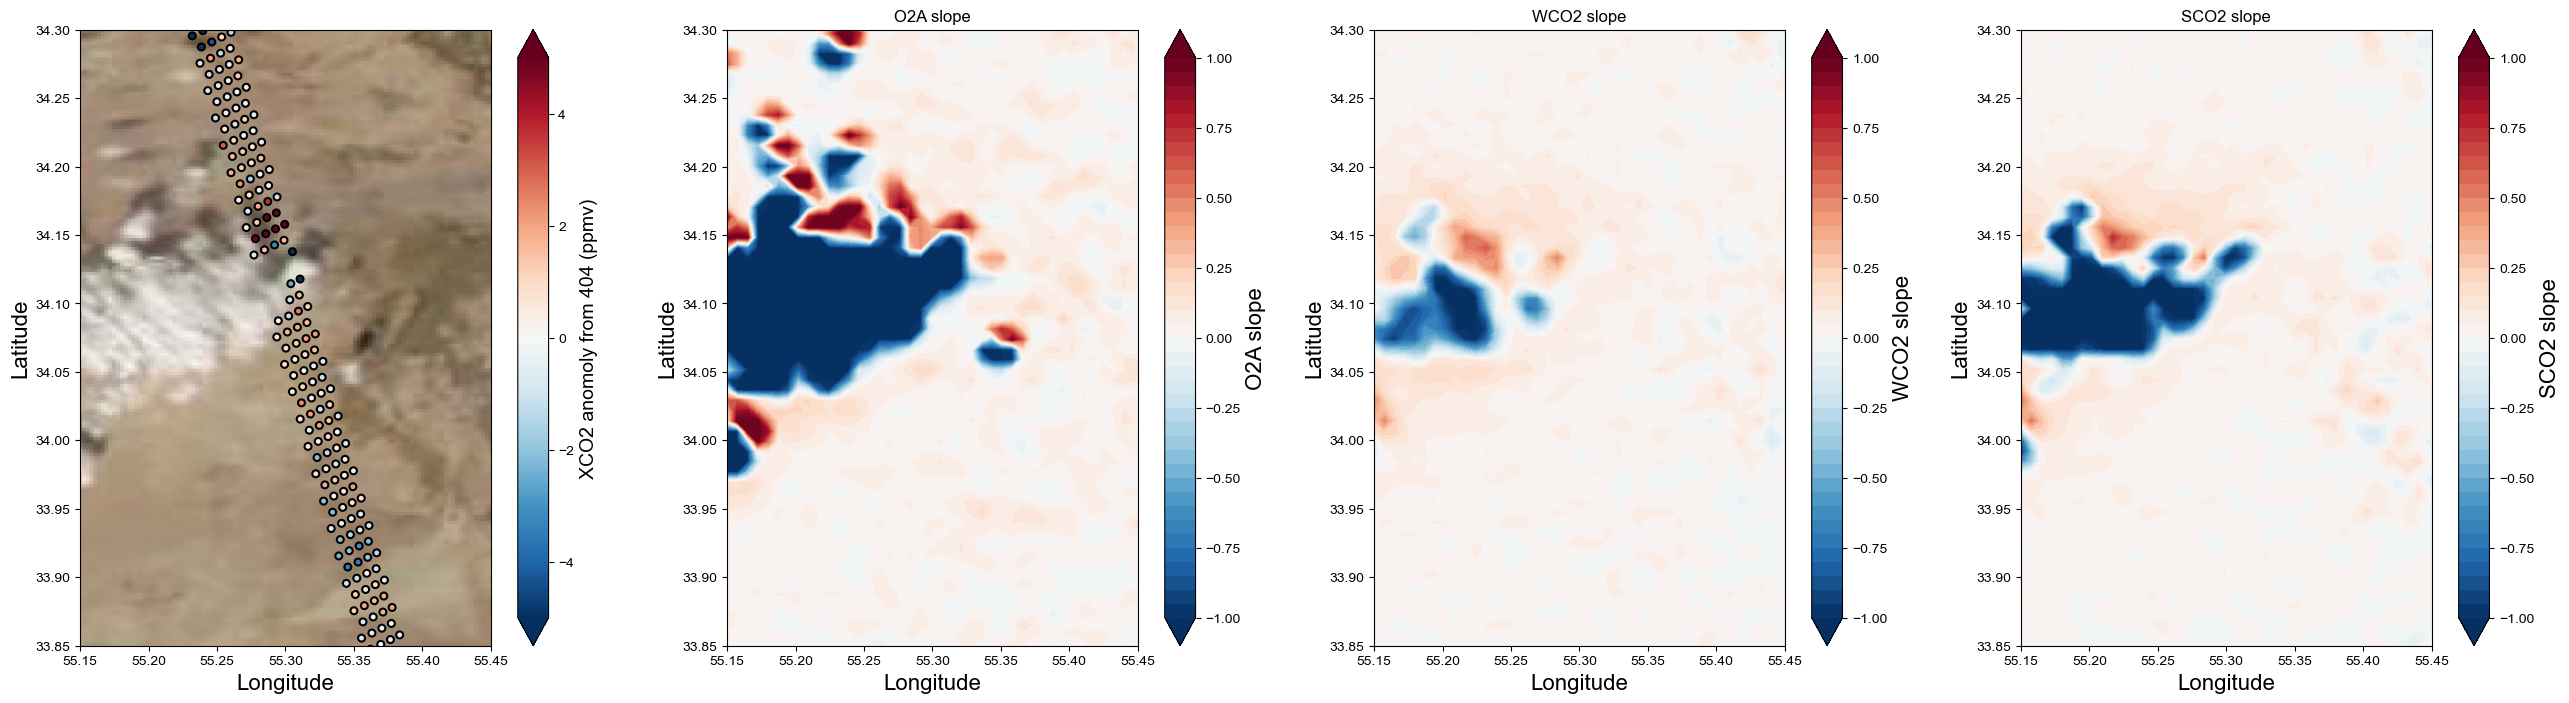

In [45]:


f, (ax0, ax1, ax2, ax3)=plt.subplots(1, 4, figsize=(32, 8))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
for ax in (ax0, ax1, ax2, ax3):
    ax.imshow(img,extent=wesn)
    ax.set_xlim(np.min(lon_dom), np.max(lon_dom))
    ax.set_ylim(np.min(lat_dom), np.max(lat_dom))
    ax.set_xlabel('Longitude', fontsize=16)
    ax.set_ylabel('Latitude', fontsize=16)
mask = np.logical_or(qf_array[:, :, 0].flatten()==0, qf_array[:, :, 0].flatten()==1)
print(mask.shape, o1.lon.shape)


# ax0

anomaly = 404
c = ax0.scatter(o1.lon.flatten(), o1.lat.flatten(),
              s=25, c=o1.co2.flatten()*1e6-anomaly,
                  vmin=-5, vmax=5,
              marker='o', edgecolors='k', linewidths=1.5, cmap='RdBu_r')
cbar = f.colorbar(c, extend='both', ax=ax0)
cbar.set_label(f'XCO2 anomoly from {anomaly} (ppmv)', fontsize=14)
#ax0.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')



# ax1

vmax = 1
vmin = -1
lev = np.arange(vmin, vmax+1e-7, 0.05)
rad_to_plot = o1.slope_1km_all[:,:,0].copy()
rad_to_plot[rad_to_plot>=vmax] = vmax
rad_to_plot[rad_to_plot<=vmin] = vmin

cc1 = ax1.contourf(o1.lon2d[:-2:3, :-2:3], o1.lat2d[:-2:3, :-2:3],  rad_to_plot, lev, cmap='RdBu_r',
                   vmin=vmin, vmax=vmax, extend='both', alpha=1)

cbar1 = f.colorbar(cc1, ax=ax1)
cbar1.set_label('O2A slope', fontsize=16)
ax1.set_title('O2A slope')



# ax2

rad_to_plot = o2.slope_1km_all[:,:,0].copy()
rad_to_plot[rad_to_plot>=vmax] = vmax
rad_to_plot[rad_to_plot<=vmin] = vmin

cc2 = ax2.contourf(o2.lon2d[:-2:3, :-2:3], o2.lat2d[:-2:3, :-2:3],  rad_to_plot, lev, cmap='RdBu_r',
                   vmin=vmin, vmax=vmax, extend='both', alpha=1)

cbar2 = f.colorbar(cc2, ax=ax2)
cbar2.set_label('WCO2 slope', fontsize=16)
ax2.set_title('WCO2 slope')


# ax3

rad_to_plot = o3.slope_1km_all[:,:,0].copy()
rad_to_plot[rad_to_plot>=vmax] = vmax
rad_to_plot[rad_to_plot<=vmin] = vmin

cc3 = ax3.contourf(o3.lon2d[:-2:3, :-2:3], o3.lat2d[:-2:3, :-2:3],  rad_to_plot, lev, cmap='RdBu_r',
                   vmin=vmin, vmax=vmax, extend='both', alpha=1)

cbar3 = f.colorbar(cc3, ax=ax3)
cbar3.set_label('SCO2 slope', fontsize=16)
ax3.set_title('SCO2 slope')



plt.show()

In [326]:
dia = h5py.File('../simulation/data/oco/oco2_L1bScND_22646a_181004_B10003r_200409075522.h5', 'r')

In [336]:
dia_lon = dia['SoundingGeometry/sounding_longitude'][...]
dia_lon_geoid = dia['SoundingGeometry/sounding_longitude_geoid'][...]
dia_lat = dia['SoundingGeometry/sounding_latitude'][...]
dai_snd = dia['SoundingGeometry/sounding_id'][...]


In [57]:
h1_unpert = h5py.File('full-unperturb_20181018_45points_avg_perturbed.h5', "r")
h1_unmodified = h5py.File('full-unperturb_20181018_45points_avg_unmodified.h5', "r")
h5_snd = h1_unpert['snd'][...]
h5_lon = h1_unpert['lon'][...]
h5_lat = h1_unpert['lat'][...]
h1_o2a_inter = h1_unpert['pert_o2'][...][:, 0]
h1_o2a_slope = h1_unpert['pert_o2'][...][:, 1]
h1_wco2_inter = h1_unpert['pert_wco2'][...][:, 0]
h1_wco2_slope = h1_unpert['pert_wco2'][...][:, 1]
h1_sco2_inter = h1_unpert['pert_sco2'][...][:, 0]
h1_sco2_slope = h1_unpert['pert_sco2'][...][:, 1]

h5_xco2_retrieved_unpert = h1_unpert['xco2_retrieved'][...]
h5_xco2_L2_file_unpert = h1_unpert['xco2_L2_file'][...]
h5_xco2_retrieved_unmodified = h1_unmodified['xco2_retrieved'][...]
h5_xco2_L2_file_unmodified = h1_unmodified['xco2_L2_file'][...]


del_XCO2_unpert_minus_unmodified = h5_xco2_retrieved_unpert - h5_xco2_retrieved_unmodified
del_XCO2_unpert_minus_L2 = h5_xco2_retrieved_unpert - h5_xco2_L2_file_unpert

compare = pd.DataFrame(np.array([h5_snd, h5_lon, h5_lat,
                                 h1_o2a_slope, h1_o2a_inter,
                                 h1_wco2_slope, h1_wco2_inter,
                                 h1_sco2_slope, h1_sco2_inter,
                                 h5_xco2_retrieved_unpert, 
                                 h5_xco2_retrieved_unmodified, 
                                 h5_xco2_L2_file_unpert]).T,
                       columns=['snd', 'lon', 'lat',
                                'o2a slope', 'o2a intercept', 
                                'wco2 slope', 'wco2 intercept',
                                'sco2 slope', 'sco2 intercept',
                                'XCO2 [unperturbed]',
                                'XCO2 [unmodified]',
                                'XCO2 [L2]',])
compare

snd        lon        lat  o2a slope  o2a intercept  wco2 slope  \
0   2.018102e+15  55.793259  32.335785   0.566609       0.046351    0.193208   
1   2.018102e+15  55.806389  32.330879   0.566609       0.046351    0.193208   
2   2.018102e+15  55.812843  32.334187   0.566609       0.046351    0.193208   
3   2.018102e+15  55.762775  32.450859  -4.398778       0.109042   -0.246010   
4   2.018102e+15  55.775902  32.445988  -4.398778       0.109042   -0.246010   
5   2.018102e+15  55.781868  32.437611  -4.398778       0.109042   -0.246010   
6   2.018102e+15  55.745758  32.499245  -4.398778       0.109042   -0.246010   
7   2.018102e+15  55.752068  32.491020  -4.398778       0.109042   -0.246010   
8   2.018102e+15  55.764496  32.474369  -4.398778       0.109042   -0.246010   
9   2.018102e+15  55.770535  32.466057  -4.398778       0.109042   -0.246010   
10  2.018102e+15  55.776501  32.457680  -4.398778       0.109042   -0.246010   
11  2.018102e+15  55.746662  32.511070  -4.398778       0.109042   -0.246010   
12  2.018102e+15  55.759102  32.494419  -4.398778       0.109042   -0.246010   
13  2.018102e+15  55.771111  32.477734  -4.398778       0.109042   -0.246010   
14  2.018102e+15  55.776989  32.469318  -4.398778       0.109042   -0.246010   
15  2.018102e+15  55.782742  32.460873  -4.398778       0.109042   -0.246010   
16  2.018102e+15  55.753704  32.514473  -4.398778       0.109042   -0.246010   
17  2.018102e+15  55.759750  32.506161  -4.398778       0.109042   -0.246010   
18  2.018102e+15  55.765724  32.497787  -4.398778       0.109042   -0.246010   
19  2.018102e+15  55.771896  32.500946  -4.398778       0.109042   -0.246010   
20  2.018102e+15  55.704037  32.598255   0.129087       0.018777    0.066805   
21  2.018102e+15  55.710342  32.590054   0.129087       0.018777    0.066805   
22  2.018102e+15  55.704834  32.610050   0.129087       0.018777    0.066805   
23  2.018102e+15  55.711067  32.601852   0.129087       0.018777    0.066805   
24  2.018102e+15  55.717258  32.593502   0.129087       0.018777    0.066805   
25  2.018102e+15  55.711773  32.613510   0.129087       0.018777    0.066805   
26  2.018102e+15  55.717834  32.605202   0.129087       0.018777    0.066805   
27  2.018102e+15  55.723820  32.596828   0.129087       0.018777    0.066805   
28  2.018102e+15  55.718361  32.616840   0.129087       0.018777    0.066805   
29  2.018102e+15  55.724258  32.608425   0.129087       0.018777    0.066805   
30  2.018102e+15  55.730015  32.599991   0.129087       0.018777    0.066805   
31  2.018102e+15  55.724560  32.620007   0.129087       0.018777    0.066805   
32  2.018102e+15  55.693195  32.689869   0.361397       0.030907    0.078626   
33  2.018102e+15  55.681538  32.718037   0.361397       0.030907    0.078626   
34  2.018102e+15  55.635761  32.821152  -7.381440       0.186691    0.036184   
35  2.018102e+15  55.642117  32.812984  -7.381440       0.186691    0.036184   
36  2.018102e+15  55.672714  32.771458  -7.381440       0.186691    0.036184   
37  2.018102e+15  55.649239  32.816574  -7.381440       0.186691    0.036184   
38  2.018102e+15  55.655350  32.808285  -7.381440       0.186691    0.036184   
39  2.018102e+15  55.655991  32.820011  -7.381440       0.186691    0.036184   
40  2.018102e+15  55.661938  32.811615  -7.381440       0.186691    0.036184   
41  2.018102e+15  55.667747  32.803200  -7.381440       0.186691    0.036184   
42  2.018102e+15  55.629047  32.985611  -3.395607       0.222388   -0.427024   
43  2.018102e+15  55.635120  32.977268  -3.395607       0.222388   -0.427024   
44  2.018102e+15  55.611149  33.022244  -3.395607       0.222388   -0.427024   

    wco2 intercept  sco2 slope  sco2 intercept  XCO2 [unperturbed]  \
0         0.052939    0.094452        0.042696          407.249209   
1         0.052939    0.094452        0.042696          408.174620   
2         0.052939    0.094452        0.042696          409.304278   
3        -0.220787   -1.185949       -0.163536      

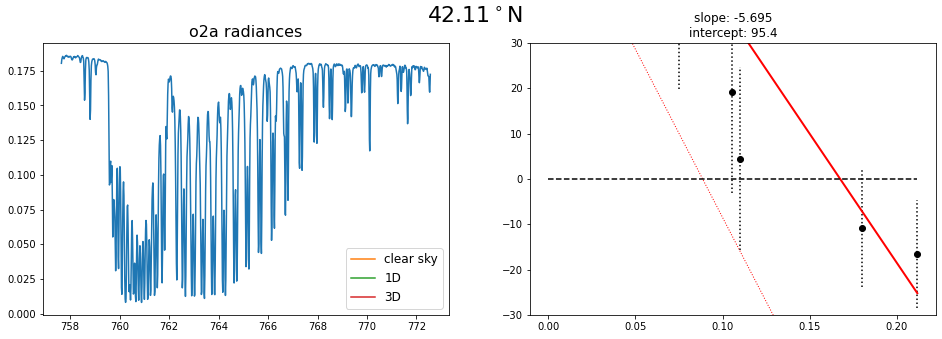

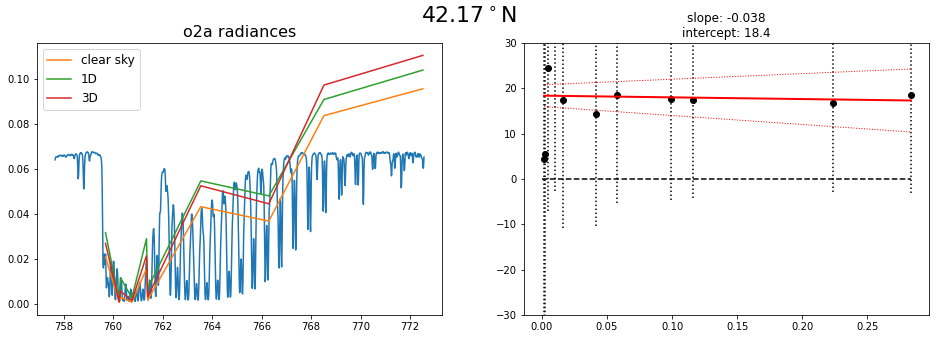

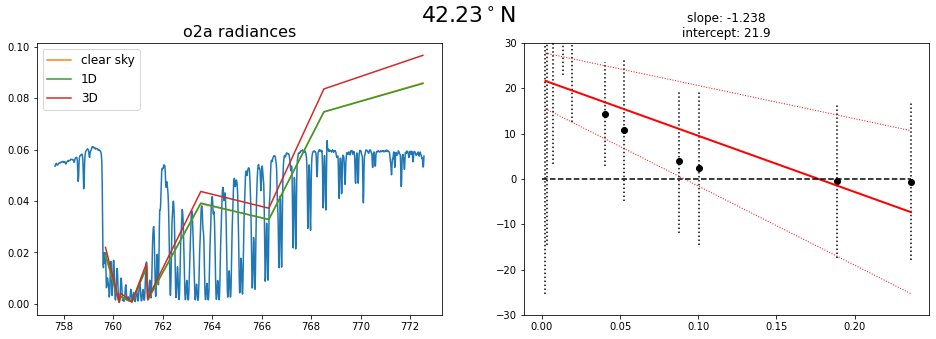

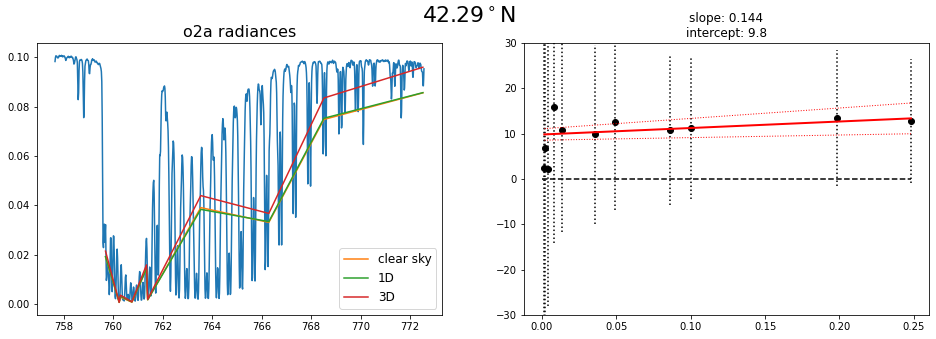

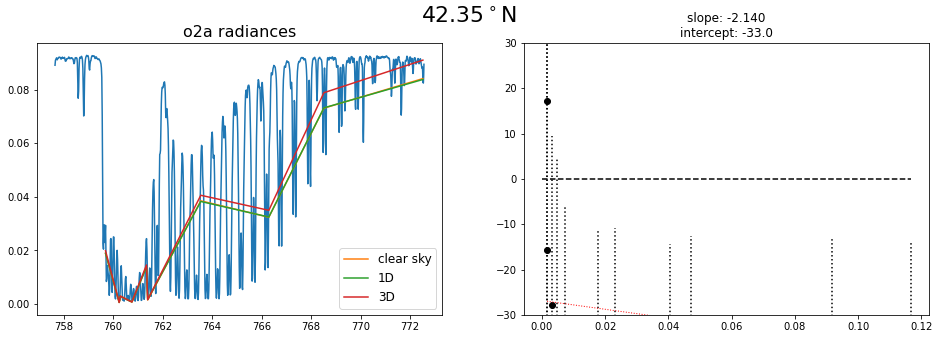

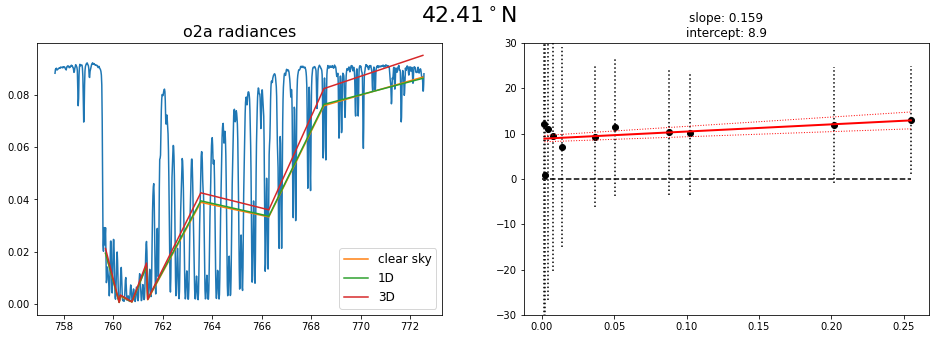

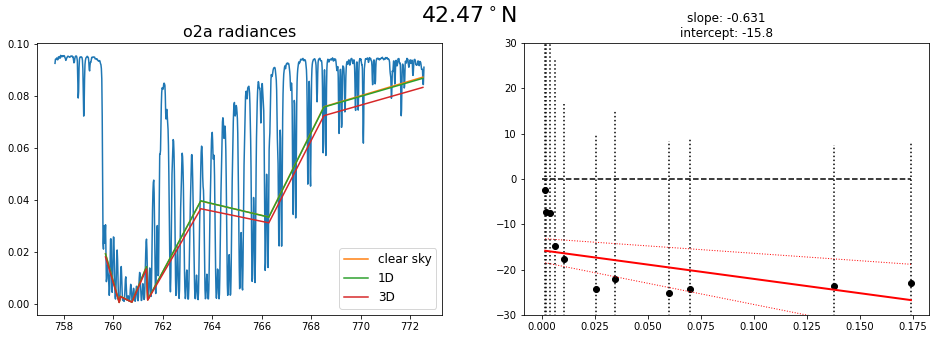

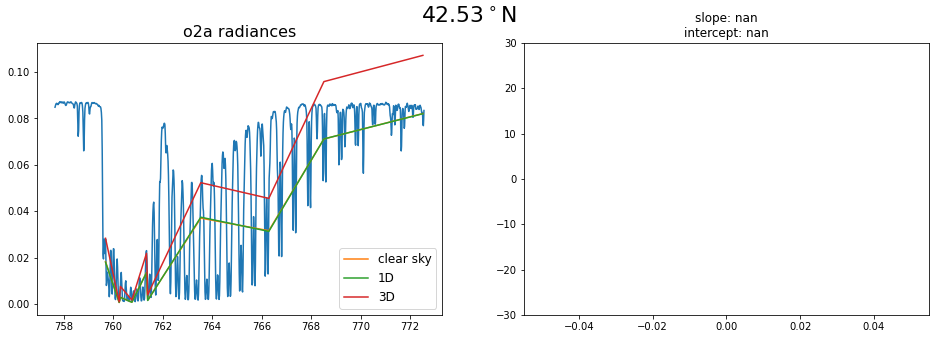

In [278]:
for i in range(0, o1.lon.shape[0],3):
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,5,))
    f.patch.set_facecolor('white')
    #plt.subplots_adjust(hspace=0.3)
    f.suptitle(f'{o1.lat[i, 0]:.2f}$^\circ$N', fontsize=22)
    j = 4
    ax0.plot(o1.wvl[i, j, :], o1.l1b[i, j, :])
    ax0.plot(o1.lam, o1.rad_1km_clr[i, j, :], label='clear sky')
    ax0.plot(o1.lam, o1.rad_1km_c1d[i, j, :], label='1D')
    ax0.plot(o1.lam, o1.rad_1km_c3d[i, j, :], label='3D')
    ax0.set_title('o2a radiances', fontsize=16)
    ax0.legend(fontsize=12)
    plot_perturbation_1km(o1, i, 1, frame=ax1)
    #o1.plot_perturbation(i, 1, frame=ax1)
    plt.show()